# Guide Me Through the Q!

![Q](images/q.png)

## Abstract

Text

##  Table of Contents

* [Part 1: Creating the Data Set](#Part-1:-Creating-the-Data-Set)
    * [1.1 Concatenating the JSON Files](#1.1-Concatenating-the-JSON-Files)
    * [1.2 Producing the Dataframe](#1.2-Producing-the-Dataframe)
    * [1.3 Cleaning](#1.3-Cleaning)
    * [1.4 Adding an Indicator for Positive Reviews](#1.4-Adding-an-Indicator-for-Positive-Reviews)
* [Part 2: Numerical Analysis](#Part-2:-Numerical-Analysis)
    * [2.1 Statistics and Trends](#2.1-Statistics-and-Trends)
    * [2.2 Training and Testing](#2.2-Training-and-Testing)
        * [2.21 Linear SVM](#2.21-Linear-SVM)
* [Part 3: Text Analysis](#Part-3:-Text-Analysis)
* [References](#References)

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

## Part 1: Creating the Data Set

### 1.1 Concatenating the JSON Files

The Q data we received consisted of about 2300 JSON files, each one representing a unique course's historical Q scores for each available semester. Out first task was to combine these individual JSON files into a single JSON Lines file; the JSON files were stored locally outside of the repository directory, and we used the `shututil` and `glob` libraries to concatenate these into `qall.jsonl`. Because the individual JSON files are local, we used the `os.path` library to check if the JSONL file already exists and to prevent the code from running if it does.

In [2]:
import shutil
import glob
import os.path

# Prevents code from running if the file already exists.
if not os.path.exists("qall.jsonl"):

    # Opens the JSONL file as output.
    with open("qall.jsonl", "wb") as outfile:
    
        # Iterates over the JSON files.
        for filename in glob.glob("../Q/*.json"):
        
            # Opens the current JSON file as input.
            with open(filename, "rb") as readfile:
            
                # Copies the JSON file to the JSONL file.
                shutil.copyfileobj(readfile, outfile)
            
                # Adds a new line as a delimiter.
                outfile.write("\n")

### 1.2 Producing the Dataframe

Each JSON file was structured using multiple nested dictionaries, with the following format:

* `scores`: a dictionary of mostly numerical data, separated by semester
    * `*semester*`: a dictionary of course and instructor scores
        * `course_score`: a dictionary of course info, ratings, and rating breakdowns
            * `overall`: a float of mean overall rating
            * `workload`: a float of mean workload rating
            * `difficulty`: a float of mean difficulty rating
            * `recommendation`: a float of mean recommendation rating
            * `enrollment`: an integer of class enrollment
            * `reponse rate`: a float of the proportion of students who reviewed the course
            * `QCourseOverall`: 
                * `number`: the string concatenation of department and course number, i.e. "COMPSCI 109"
                * `course_id`: an integer identifier for my.harvard.edu
                * `cat_num`: an integer indentifier for the Harvard Course Catalog
                * `1s`: an integer count of reviews with rating 1 for this category
                * `2s`: analagous, with 2s
                * `3s`: analagous, with 3s
                * `4s`: analagous, with 4s
                * `5s`: analagous, with 5s
            * `QDifficulty`: analagous to `QCourseOverall`, with difficulty ratings.
            * `QWorkload`: analagous to `QCourseOverall`, with workload ratings.
        * `instructor_scores`: a list of length 1 that contains a dictionary of instructor info and ratings
            * `number`: identical to that within `QCourseOverall`
            * `cat_num`: identical to that within `QCourseOverall`
            * `course_id`: identical to that within `QCourseOverall`
            * `year`: an int of the first of the two years represented in the given school year
            * `term`: an int with value 1 if the course took place in the Fall, 2 if Spring
            * `id`: a string indentifier of the professor
            * `first`: a string of the first name of the professor
            * `last`: a string of the last name
            * `InstructorOverall`: a float of mean overall instructor rating
            * `EffectiveLecturesorPresentations`: a float of mean lecture rating
            * `AccessibleOutsideClass`: a float of mean accessibility rating
            * `GeneratesEnthusiasm`: a float of mean enthusiasm rating
            * `FacilitatesDiscussionEncouragesParticipation`: a float of mean facilitation rating
            * `GivesUsefulFeedback`: a float of mean feedback rating
            * `ReturnsAssignmentsinTimelyFashion`: a float of mean timeliness rating
* `comments`: a dictionary of textual reviews, separated by semester into dictionaries
    * `*semester*`: a dictionary of comments for the given semester
        * `comments`: a list of strings that represent comments
* `mostRecentQ`: identical to the most recent semester data in `scores`
* `success`: indicates if the JSON was successfully retrieved

Any mean rating has range `1.0-5.0`, and response rate has a range `0.0-1.0`. The entries labeled `*semester*` can occur any number of times and have as a key the semester in which it took place (i.e. `Fall '12`).

We wanted our first dataframe `bigdf` to have a single row for each instance of a course (`COMPSCI 109` in `Fall '13` and `COMPSCI 109` in `Fall '14` have separate rows). This versatile dataframe could be adjusted in a number of different ways to suit the purposes of our data analysis. One caveat was a lack of course or instructor data, or both! To handle for this, we first created an empty dataframe with specified columns; then, we loaded the data for each cousrse using the `json` library, created a minimal dictionary for each semester, added further semester data to the dictionary conditional upon the data's existence, then appended that dictionary to the dataframe.

In [3]:
import json

# Creates the dataframe with columns specified.
bigdf = pd.DataFrame(columns=["C_Department","C_Number", "Course", "C_CatNum","C_ID","C_Semester","C_Year","C_Term",
                              "C_Overall","C_Workload","C_Difficulty","C_Recommendation","C_Enrollment","C_ResponseRate",
                              "I_First","I_Last","I_ID",
                              "I_Overall","I_EffectiveLectures","I_Accessible","I_GeneratesEnthusiasm",
                              "I_EncouragesParticipation","I_UsefulFeedback","I_ReturnsAssignmentsTimely",
                              "QOverall_1","QOverall_2","QOverall_3","QOverall_4","QOverall_5",
                              "QDifficulty_1","QDifficulty_2","QDifficulty_3","QDifficulty_4","QDifficulty_5",
                              "QWorkload_1","QWorkload_2","QWorkload_3","QWorkload_4","QWorkload_5",
                              "Comments"])

# Opens the JSONL file as the input.
with open("qall.jsonl") as data_file:

    # Iterates over each line.
    for line in data_file:

        # Loads the JSON.
        alldata = json.loads(line)

        # Iterates over each semester for the course.
        for semester in alldata["scores"]:

            # Retrieves the semester data.
            semdata = alldata["scores"][semester]

            # Retrieves the scores or comments if they exist, else None.
            cscores = semdata["course_score"] if "course_score" in semdata else None
            iscores = semdata["instructor_scores"][0] if "instructor_scores" in semdata else None
            comments = alldata["comments"][semester]["comments"] if semester in alldata["comments"] else None

            # Creates a dictionary that will be appended as a row to the dataframe.
            semdatadict = {"C_Semester": semester, "Comments": comments}

            # If the course scores exist...
            if cscores != None:
                
                # Retrieves the course name and separates it into department and number.
                course = str(cscores["QCourseOverall"]["number"]).split()
                if course[0] == "None":
                    course = [None, None]
                    fullname = "NODEPT-NOCOURSENUMBER"
                else:
                    fullname = course[0] + "-" + course[1]
                    
                # Updates the dictionary with the data.
                semdatadict.update({"C_Department": course[0],
                                    "C_Number": course[1],
                                    "Course": fullname,
                                    "C_CatNum": cscores["QCourseOverall"]["cat_num"],
                                    "C_ID": cscores["QCourseOverall"]["course_id"],
                                    "C_Overall": cscores["overall"],
                                    "C_Workload": cscores["workload"],
                                    "C_Difficulty": cscores["difficulty"],
                                    "C_Recommendation": cscores["recommendation"],
                                    "C_Enrollment": cscores["enrollment"],
                                    "C_ResponseRate": cscores["response rate"],
                                    "QOverall_1": cscores["QCourseOverall"]["1s"],
                                    "QOverall_2": cscores["QCourseOverall"]["2s"],
                                    "QOverall_3": cscores["QCourseOverall"]["3s"],
                                    "QOverall_4": cscores["QCourseOverall"]["4s"],
                                    "QOverall_5": cscores["QCourseOverall"]["5s"],
                                    "QDifficulty_1": cscores["QDifficulty"]["1s"],
                                    "QDifficulty_2": cscores["QDifficulty"]["2s"],
                                    "QDifficulty_3": cscores["QDifficulty"]["3s"],
                                    "QDifficulty_4": cscores["QDifficulty"]["4s"],
                                    "QDifficulty_5": cscores["QDifficulty"]["5s"],
                                    "QWorkload_1": cscores["QWorkload"]["1s"],
                                    "QWorkload_2": cscores["QWorkload"]["2s"],
                                    "QWorkload_3": cscores["QWorkload"]["3s"],
                                    "QWorkload_4": cscores["QWorkload"]["4s"],
                                    "QWorkload_5": cscores["QWorkload"]["5s"],})

            # If the instructor scores exist...
            if iscores != None:

                # Retrieves the course name and separates it into department and number.
                course = str(iscores["number"]).split()
                if course[0] == "None":
                    course = [None, None]
                    fullname = "NODEPT-NOCOURSENUMBER"
                else:
                    fullname = course[0] + "-" + course[1]

                # Updates the dictionary with the data.
                semdatadict.update({"C_Department": course[0],
                                    "C_Number": course[1],
                                    "Course": fullname,
                                    "C_CatNum": iscores["cat_num"],
                                    "C_ID": iscores["course_id"],
                                    "C_Year": iscores["year"],
                                    "C_Term": iscores["term"],
                                    "I_First": iscores["first"].strip(),
                                    "I_Last": iscores["last"].strip(),
                                    "I_ID": iscores["id"],
                                    "I_Overall": iscores["InstructorOverall"],
                                    "I_EffectiveLectures": iscores["EffectiveLecturesorPresentations"],
                                    "I_Accessible": iscores["AccessibleOutsideClass"],
                                    "I_GeneratesEnthusiasm": iscores["GeneratesEnthusiasm"],
                                    "I_EncouragesParticipation": iscores["FacilitatesDiscussionEncouragesParticipation"],
                                    "I_UsefulFeedback": iscores["GivesUsefulFeedback"],
                                    "I_ReturnsAssignmentsTimely": iscores["ReturnsAssignmentsinTimelyFashion"]})

            # Adds the dictionary as a row to the dataframe.
            bigdf = bigdf.append(semdatadict, ignore_index=True)

Here is a look at the resulting dataframe:

In [4]:
bigdf.head(5)

,C_Department,C_Number,Course,C_CatNum,C_ID,C_Semester,C_Year,C_Term,C_Overall,C_Workload,C_Difficulty,C_Recommendation,C_Enrollment,C_ResponseRate,I_First,I_Last,I_ID,I_Overall,I_EffectiveLectures,I_Accessible,I_GeneratesEnthusiasm,I_EncouragesParticipation,I_UsefulFeedback,I_ReturnsAssignmentsTimely,QOverall_1,QOverall_2,QOverall_3,QOverall_4,QOverall_5,QDifficulty_1,QDifficulty_2,QDifficulty_3,QDifficulty_4,QDifficulty_5,QWorkload_1,QWorkload_2,QWorkload_3,QWorkload_4,QWorkload_5,Comments
0,HISTSCI,270,HISTSCI-270,58523,2697,Spring '12,2011,2,4.67,2.33,3.33,5.00,6,50.00,Rebecca,Lemov,79de794d3e2e19eb71a2033b0ec0b76d,4.67,4.33,4.00,4.33,5.00,4.50,4.00,0,0,0,1,2,0,0,2,1,0,0,2,1,0,0,[This course is a perfect example of what grea...
1,EXPOS,20.132,EXPOS-20.132,22108,1676,Fall '14,2014,1,4.10,7.10,None,3.50,13,76.92,Owen,Chen,1341ccb7bd27f47e68625b63b15281d1,4.50,4.60,3.70,3.90,3.90,4.10,4.60,0,1,1,4,4,0,1,2,7,3,1,3,4,1,0,"[The class has a fairly high work load, but Dr..."
2,EXPOS,20.132,EXPOS-20.132,22108,1676,Fall '13,2013,1,3.50,2.60,3.90,3.20,13,100.00,Owen,Chen,1341ccb7bd27f47e68625b63b15281d1,3.80,4.00,2.50,3.50,4.10,4.30,4.40,0,1,1,4,4,0,1,2,7,3,1,3,4,1,0,[Philosophy of the State with Dr. Chen offers ...
3,EXPOS,20.132,EXPOS-20.132,22108,1676,Fall '12,2012,1,3.73,2.47,3.67,3.47,15,100.00,Owen,Chen,1341ccb7bd27f47e68625b63b15281d1,3.87,4.33,2.64,3.93,4.18,3.64,3.82,0,1,1,4,4,0,1,2,7,3,1,3,4,1,0,[This was by far my favorite course. Dr. Chen ...
4,EXPOS,20.132,EXPOS-20.132,22108,1676,Fall '11,2011,1,3.85,2.00,3.54,3.62,13,100.00,Owen,Chen,1341ccb7bd27f47e68625b63b15281d1,4.08,3.75,3.31,3.92,4.46,4.23,4.08,0,1,1,4,4,0,1,2,7,3,1,3,4,1,0,"[Be prepared to read, Discussions were great, ..."


### 1.3 Cleaning

If the instructor data was missing for a course, `C_Year` and `C_Term` were left out. We iterated over each row to extract this information from `C_semester`:

In [5]:
# Iterates over each row in the dataframe
for index, row in bigdf.iterrows():

    # Retrieves the year.
    year = int(row["C_Semester"][-2:])

    # Based on semester, determines year and term.
    if row["C_Semester"][0:4] == "Fall":
        row["C_Term"] = 1
        row["C_Year"] = 2000 + year
    elif row["C_Semester"][0:6] == "Spring":
        row["C_Term"] = 2
        row["C_Year"] = 1999 + year
    else:
        continue

We decided to delete course that has no department or number. Although there is textual data in the comments, the missing number is a result of having no course and instructor scores, so there is little we can do with it numerically:

In [6]:
bigdf = bigdf[bigdf["C_Department"]==bigdf["C_Department"]]
bigdf = bigdf[bigdf["C_Department"]!=None]

Then, we adjusted the types of each column to prepare for data analysis. We created a dictionary `coltypes` with keys as types and values as a list of the columns that should be those types. All columns except `Comments` were categorized as either an `int`, a `float`, or a `string`:

In [7]:
coltypes = {int: ["C_CatNum","C_ID","C_Year","C_Term","C_Enrollment",
                  "QOverall_1","QOverall_2","QOverall_3","QOverall_4","QOverall_5",
                  "QDifficulty_1","QDifficulty_2","QDifficulty_3","QDifficulty_4","QDifficulty_5",
                  "QWorkload_1","QWorkload_2","QWorkload_3","QWorkload_4","QWorkload_5"],
            float: ["C_Overall","C_Workload","C_Difficulty","C_Recommendation","C_ResponseRate",
                    "I_Overall","I_EffectiveLectures","I_Accessible","I_GeneratesEnthusiasm",
                    "I_EncouragesParticipation","I_UsefulFeedback","I_ReturnsAssignmentsTimely",
                    "QOverall_1","QOverall_2","QOverall_3","QOverall_4","QOverall_5"],
            str: ["C_Number","C_Department","C_Semester","I_First","I_Last","I_ID"]}

Some of the `string` cells contained unicode that could not be written to a csv. Using the `unidecode` library, we converted these to writable strings:

In [8]:
from unidecode import unidecode

for index, row in bigdf.iterrows():
    for strcol in coltypes[str]:
        try:
            str(row[strcol])
        except UnicodeEncodeError:
            bigdf.loc[index, row[row.values==row[strcol]].index[0]] = unidecode(row[strcol])

Then, we replaced `None` values with `NaN` for floats and `-1` for ints.

In [9]:
for intcol in coltypes[int]:
    bigdf = bigdf.replace({intcol: {None: -1, "": -1}})

for floatcol in coltypes[float]:
    bigdf = bigdf.replace({floatcol: {None: np.nan}})

To finish correcting the types, we cast the entire columns as the desired type using the keys in `coltypes`:

In [10]:
for ctp in coltypes:
    for col in coltypes[ctp]:
        bigdf[col] = bigdf[col].astype(ctp)

### 1.4 Adding an Indicator for Positive Reviews

In order to provide some useful insight on what makes a good class, we had to determine how to classify courses as positive or negative. Ultimately, we decided that the threshold should be the median of overall q scores in the given semester, so that half of the courses would be good and half would be bad. We grouped by semester in order to reduce the effect of semester-specific events that could possibly shift that semester's scores.

In [11]:
# Adds an empty series for the semester median to the dataframe.
bigdf["Sem_Median"] = pd.Series(index=bigdf.index)

# Iterates over each semester, adding the semester median to the series.
for name, group in bigdf.groupby(["C_Year", "C_Term"]):
    bigdf.loc[(bigdf["C_Year"]==name[0])&(bigdf["C_Term"]==name[1]), "Sem_Median"] = np.nanmedian(group["C_Overall"].values)

# Determines whether or not a review is positive by comparing the Q score to the semester median.
bigdf["Positive"] = pd.Series(bigdf["C_Overall"]>=bigdf["Sem_Median"], index=bigdf.index)

Here is a look at the final data set:

In [12]:
bigdf.head(5)

,C_Department,C_Number,Course,C_CatNum,C_ID,C_Semester,C_Year,C_Term,C_Overall,C_Workload,C_Difficulty,C_Recommendation,C_Enrollment,C_ResponseRate,I_First,I_Last,I_ID,I_Overall,I_EffectiveLectures,I_Accessible,I_GeneratesEnthusiasm,I_EncouragesParticipation,I_UsefulFeedback,I_ReturnsAssignmentsTimely,QOverall_1,QOverall_2,QOverall_3,QOverall_4,QOverall_5,QDifficulty_1,QDifficulty_2,QDifficulty_3,QDifficulty_4,QDifficulty_5,QWorkload_1,QWorkload_2,QWorkload_3,QWorkload_4,QWorkload_5,Comments,Sem_Median,Positive
0,HISTSCI,270,HISTSCI-270,58523,2697,Spring '12,2011,2,4.67,2.33,3.33,5.00,6,50.00,Rebecca,Lemov,79de794d3e2e19eb71a2033b0ec0b76d,4.67,4.33,4.00,4.33,5.00,4.50,4.00,0,0,0,1,2,0,0,2,1,0,0,2,1,0,0,[This course is a perfect example of what grea...,4.30,True
1,EXPOS,20.132,EXPOS-20.132,22108,1676,Fall '14,2014,1,4.10,7.10,NaN,3.50,13,76.92,Owen,Chen,1341ccb7bd27f47e68625b63b15281d1,4.50,4.60,3.70,3.90,3.90,4.10,4.60,0,1,1,4,4,0,1,2,7,3,1,3,4,1,0,"[The class has a fairly high work load, but Dr...",4.30,False
2,EXPOS,20.132,EXPOS-20.132,22108,1676,Fall '13,2013,1,3.50,2.60,3.90,3.20,13,100.00,Owen,Chen,1341ccb7bd27f47e68625b63b15281d1,3.80,4.00,2.50,3.50,4.10,4.30,4.40,0,1,1,4,4,0,1,2,7,3,1,3,4,1,0,[Philosophy of the State with Dr. Chen offers ...,4.30,False
3,EXPOS,20.132,EXPOS-20.132,22108,1676,Fall '12,2012,1,3.73,2.47,3.67,3.47,15,100.00,Owen,Chen,1341ccb7bd27f47e68625b63b15281d1,3.87,4.33,2.64,3.93,4.18,3.64,3.82,0,1,1,4,4,0,1,2,7,3,1,3,4,1,0,[This was by far my favorite course. Dr. Chen ...,4.25,False
4,EXPOS,20.132,EXPOS-20.132,22108,1676,Fall '11,2011,1,3.85,2.00,3.54,3.62,13,100.00,Owen,Chen,1341ccb7bd27f47e68625b63b15281d1,4.08,3.75,3.31,3.92,4.46,4.23,4.08,0,1,1,4,4,0,1,2,7,3,1,3,4,1,0,"[Be prepared to read, Discussions were great, ...",4.20,False


Now, we write this to a csv file for safekeeping.

In [13]:
bigdf.to_csv("bigdf.csv", index=False)

## Part 2: Numerical Analysis

### 2.1 Statistics and Trends

First, we plotted the distribution of overall course scores by semester as a part of our exploratory analysis. We can observe that there is a high density around the `4-5` range, with a mean of `4.18` and a median of `4.25`, indicating that the histogram is skewed left.

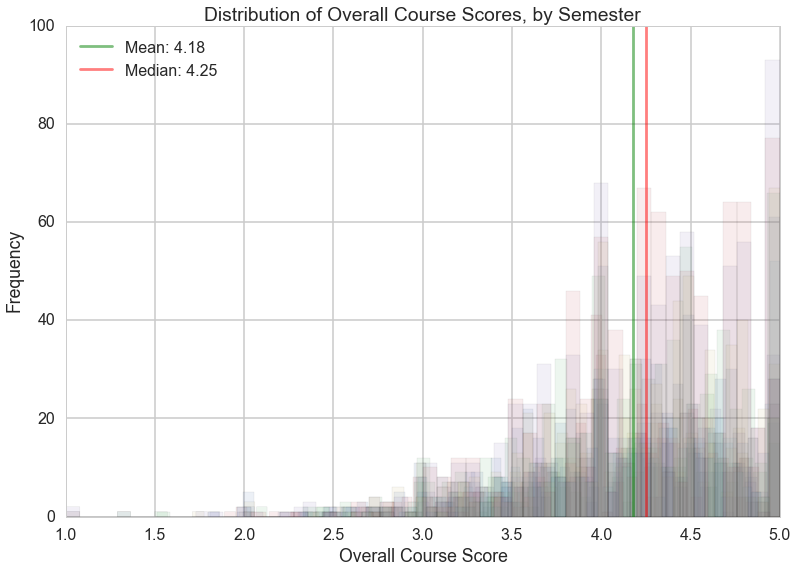

In [41]:
plt.plot();

# Plots a histogram of each semester's overall course scores.
for name, group in bigdf.groupby(["C_Year", "C_Term"]):
    group["C_Overall"].hist(bins=50, alpha=0.1);

# Calculates the mean and median.
mean = bigdf["C_Overall"].mean()
median = bigdf["C_Overall"].median()

# Adds the mean and median to the histogram, with a legend.
plt.axvline(mean, color="green", label="Mean: %0.2f" % mean, alpha=0.5);
plt.axvline(median, color ="red", label="Median: %0.2f" % median, alpha=0.5);
plt.legend(loc="upper left");

# Formats the plot.
plt.xlim(1,5);
plt.xlabel("Overall Course Score");
plt.ylabel("Frequency");
plt.title("Distribution of Overall Course Scores, by Semester");

We can take a look at the highest and lowest rated classes.

using `groupby`. The CHEMBIO department has the lowest average course scores at about `3.12`, and the PLSH, MEDGREEK, PAL, and GIKUYU departments have had perfect scores for each course in Q guide history. The perfect scores are likely due to low enrollment and people who self-select into those course offerings, whereas the low scores are coming from difficult science departments that could offering requirements for the premed track or other rigorous curricula.

In [42]:
#ASDF

We can take a look at the highest rated departments and the lowest, using `groupby`. The CHEMBIO department has the lowest average course scores at about `3.12`, and the PLSH, MEDGREEK, PAL, and GIKUYU departments have had perfect scores for each course in Q guide history. The perfect scores are likely due to low enrollment and people who self-select into those course offerings, whereas the low scores are coming from difficult science departments that could offering requirements for the premed track or other rigorous curricula.

In [43]:
# Creates a series of department mean overall course scores.
deprank = bigdf.groupby("C_Department")["C_Overall"].mean()

# Prints the top 5 and bottom 5 departments.
deprank.sort(ascending=False)
print "TOP 5 DEPARTMENTS:\n", deprank.head(5), "\n"
deprank.sort(ascending=True)
print "BOTTOM 5 DEPARTMENTS:\n", deprank.head(5)

TOP 5 DEPARTMENTS:
C_Department
PLSH        5.000000
MEDGREEK    5.000000
PAL         5.000000
GIKUYU      5.000000
ROM-LANG    4.966667
Name: C_Overall, dtype: float64 

BOTTOM 5 DEPARTMENTS:
C_Department
CHEMBIO       3.116667
BCMP          3.446429
APPHY         3.577692
SCI-PHYUNV    3.585806
APMTH         3.653625
Name: C_Overall, dtype: float64


Another interesting trend is the slight discrepancy between Fall scores and Spring scores. In the entire history of the Q, Fall score means have been consistently lower than those in the Spring. However, both have risen over time.

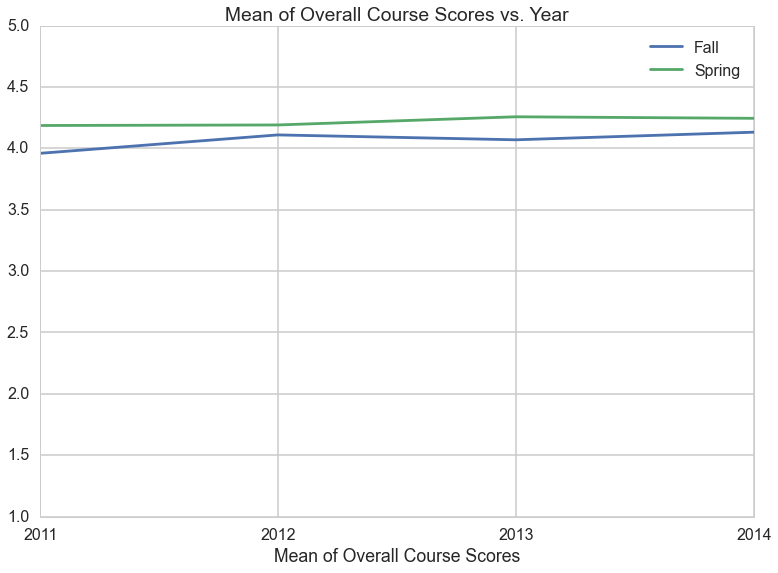

In [44]:
# Creates a series of semester mean overall course scores.
semrank = bigdf.groupby("C_Semester")["C_Overall"].mean()

# Plots by semester.
semrank[0:4].plot(label="Fall")
semrank[5:9].plot(label="Spring")

# Formats and labels the plot.
plt.xticks(range(4),['2011','2012','2013','2014']);
plt.ylim(1,5)
plt.xlabel("Year")
plt.xlabel("Mean of Overall Course Scores")
plt.title("Mean of Overall Course Scores vs. Year")
plt.legend();

### 2.2 Training and Testing

In order to figure out which numerical data are most responsible for the overall course score, we created a copy of the dataframe specifically for numerical analysis, then removed certain columns that we should avoid running regressions on, such as the breakdown of ratings (how many 1s, 2s, etc.), the textual reviews, any string fields, and the course catalog number and id; for the sake of easily identifying courses, we kept department, number, and semester. We removed all reviews from `Fall '14`, as the format of the Q guide changed that semester. Finally, we dropped all rows with missing data.

In [45]:
# Copies the big dataframe.
numdf = bigdf.copy()

# Drops columns that we will not be needing.
numdf = numdf.drop(numdf.columns[[2,3,4,6,7,11]+list(range(13,17))+list(range(24,40))], axis=1)

# Removes Fall '14 data.
numdf = numdf[numdf["C_Semester"] != "Fall '14"]

# Drops rows with missing data.
numdf = numdf.dropna(how="any")

Here is the resulting dataframe for our numerical analysis:

In [46]:
numdf.head(5)

,C_Department,C_Number,C_Semester,C_Overall,C_Workload,C_Difficulty,C_Enrollment,I_Overall,I_EffectiveLectures,I_Accessible,I_GeneratesEnthusiasm,I_EncouragesParticipation,I_UsefulFeedback,I_ReturnsAssignmentsTimely,Sem_Median,Positive
0,HISTSCI,270,Spring '12,4.67,2.33,3.33,6,4.67,4.33,4.00,4.33,5.00,4.50,4.00,4.30,True
2,EXPOS,20.132,Fall '13,3.50,2.60,3.90,13,3.80,4.00,2.50,3.50,4.10,4.30,4.40,4.30,False
3,EXPOS,20.132,Fall '12,3.73,2.47,3.67,15,3.87,4.33,2.64,3.93,4.18,3.64,3.82,4.25,False
4,EXPOS,20.132,Fall '11,3.85,2.00,3.54,13,4.08,3.75,3.31,3.92,4.46,4.23,4.08,4.20,False
5,EXPOS,20.133,Spring '13,4.42,2.58,3.50,12,4.67,4.50,4.08,4.42,4.70,4.60,4.30,4.29,True


Next, we split the data into training and test sets. Since we are trying to use previous Q data to predict next semester's, we tested on `Spring '14` data and trained on the data in previous semesters.

In [47]:
# Separates Spring '14 into the test set and the rest into the training set.
train = numdf[numdf["C_Semester"] != "Spring '14"]
test = numdf[numdf["C_Semester"] == "Spring '14"]

# Prints the size of the sets.
print "Length of Train is:", len(train)
print "Length of Test is: ", len(test)

Length of Train is: 4953
Length of Test is:  604


Because we included non-numerical columns in the dataframe, we created a list `lcols` to specify which columns should be used for training.

In [48]:
# Creates a list of all the columns we have in the numerical dataframe.
lcols = list(train.columns)

# Removes columns we do not need for training.
for c in ["C_Department","C_Number","C_Semester","C_Overall","Sem_Median","Positive"]:
    lcols.remove(c)

# Shows the remaining columns.
lcols

['C_Workload',
 'C_Difficulty',
 'C_Enrollment',
 'I_Overall',
 'I_EffectiveLectures',
 'I_Accessible',
 'I_GeneratesEnthusiasm',
 'I_EncouragesParticipation',
 'I_UsefulFeedback',
 'I_ReturnsAssignmentsTimely']

Now, we will separate the response variable, `Positive`, from the data in `lcols`.

In [49]:
# Creates the X matrix.
Xtrain = train[lcols].values
Xtest = test[lcols].values

# Creates the y response vector.
ytrain = train["Positive"].values
ytest = test["Positive"].values

#### 2.21 Linear SVM

As in homework 3, we will start off with a Linear SVM because of its quickness, running `GridSearchCV` over a range of regularization coefficients with 5-fold cross validation.

In [50]:
from sklearn.svm import LinearSVC
from sklearn.grid_search import GridSearchCV

# Creates a Linear SVM to be trained.
clfsvm = LinearSVC(loss="hinge")

# Creates a list of regularization coefficients to be used.
Cs = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

# Performs a grid serach on the Linear SVM
gs = GridSearchCV(clfsvm, param_grid={'C':Cs}, cv=5)
gs.fit(Xtrain, ytrain)

# Prints the best C value and its accuracy.
print "The best value of C is: %0.3f" % gs.best_params_["C"]
print "The accuracy is:        %0.4f" % gs.best_score_

The best value of C is: 1.000
The accuracy is:        0.8373


Now, we will refit the data again using the best classifier given by the grid search.

In [51]:
# Stores the best classifier.
best = gs.best_estimator_

# Refits the training data.
best.fit(Xtrain, ytrain)

# Prints the refitted accuracy.
print "Refitting the training data with C = %0.3f:" % gs.best_params_["C"]
print "Training accuracy is: %0.4f" % best.score(Xtrain, ytrain)
print "Test accuracy is:     %0.4f" % best.score(Xtest, ytest)

Refitting the training data with C = 1.000:
Training accuracy is: 0.7737
Test accuracy is:     0.7632


#### 2.22 Logistic Regression

Now, we will move onto a logistic regression.

In [52]:
from sklearn.linear_model import LogisticRegression 

model = LogisticRegression()
logisticmodel = model.fit(Xtrain, ytrain)

# Prints the accuracies on both sets.
print "Training accuracy is:", model.score(Xtrain, ytrain) 
print "Test accuracy is:    ", model.score(Xtest, ytest)

Training accuracy is: 0.85523924894
Test accuracy is:     0.854304635762


In [53]:
from sklearn.ensemble import RandomForestClassifier  
from sklearn import ensemble

rf = RandomForestClassifier(n_estimators=100)
rfmodel = rf.fit(Xtrain, ytrain) 

In [54]:
acc = rfmodel.score(Xtest,ytest) 
acc

0.86092715231788075

In [55]:
from sklearn.metrics import roc_curve, auc

def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):

    initial = False

    if not ax:
        ax = plt.gca()
        initial=True

    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds = roc_curve(ytest, clf.decision_function(xtest))

    roc_auc = auc(fpr, tpr)

    if skip:
        l = fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))

    label_kwargs = {}
    label_kwargs['bbox'] = dict(boxstyle='round,pad=0.3', alpha=0.2)

    if labe!=None:
        for k in xrange(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)

    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')

    ax.legend(loc="lower right")

    return ax

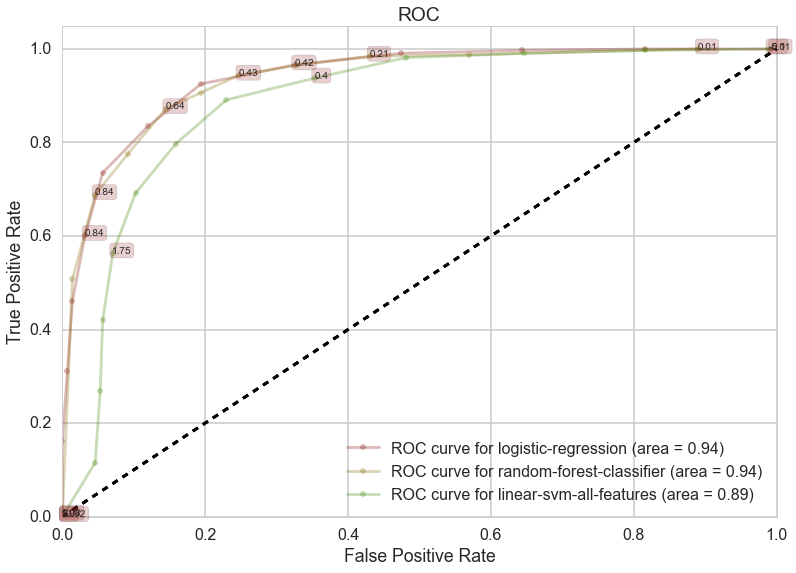

In [56]:
with sns.hls_palette(8, l=.3, s=.8):
    ax = make_roc("logistic-regression", model, ytest, Xtest, labe=200, skip=50) 
    ax = make_roc("random-forest-classifier", rfmodel, ytest, Xtest, labe=20, skip=10) 
    ax = make_roc("linear-svm-all-features", best, ytest, Xtest, labe=200, proba=False, skip=50)   

In [57]:
def nonzero_lasso(clf):
    featuremask = (clf.coef_ !=0.0)[0]
    return pd.DataFrame(dict(feature=lcols, coef=clf.coef_[0], abscoef=np.abs(clf.coef_[0])))[featuremask].sort('abscoef', ascending=False) 

lasso_importances = nonzero_lasso(best)
lasso_importances.set_index("feature", inplace=True)
lasso_importances.reset_index("feature", inplace=True)
lasso_importances

,feature,abscoef,coef
0,I_Overall,2.075871,2.075871
1,I_GeneratesEnthusiasm,0.573253,0.573253
2,C_Difficulty,0.407715,-0.407715
3,I_EffectiveLectures,0.399844,0.399844
4,C_Workload,0.324239,0.324239
5,I_Accessible,0.270809,-0.270809
6,I_EncouragesParticipation,0.232546,0.232546
7,I_ReturnsAssignmentsTimely,0.130053,0.130053
8,C_Enrollment,0.017747,0.017747
9,I_UsefulFeedback,0.014422,0.014422


In [58]:
#Let's run a pipelined classifier with feature selection to see if we can improve our classifier.  
from sklearn import feature_selection
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from scipy.stats import pearsonr

def pearson_scorer(X,y):
    rs = np.zeros(X.shape[1])
    pvals = np.zeros(X.shape[1])
    i = 0
    for v in X.T:
        rs[i], pvals[i] = pearsonr(v, y)
        i = i + 1
    return np.abs(rs), pvals

selectorlinearsvm = SelectKBest(k=10, score_func=pearson_scorer)
pipelinearsvm = Pipeline([('select', selectorlinearsvm), ('svm', LinearSVC(loss="hinge"))])

In [59]:
# Now we can see if our pipeline linear SVM classifier with feature select did better than our original linear SVM classifier.
pipeline = pipelinearsvm.fit(Xtrain, ytrain) 
pipeline.score(Xtest, ytest) 

0.86258278145695366

In [60]:
#What features did the pipeline classifier select? 
np.array(lcols)[pipeline.get_params()["select"].get_support()]

array(['C_Workload', 'C_Difficulty', 'C_Enrollment', 'I_Overall',
       'I_EffectiveLectures', 'I_Accessible', 'I_GeneratesEnthusiasm',
       'I_EncouragesParticipation', 'I_UsefulFeedback',
       'I_ReturnsAssignmentsTimely'], 
      dtype='|S26')

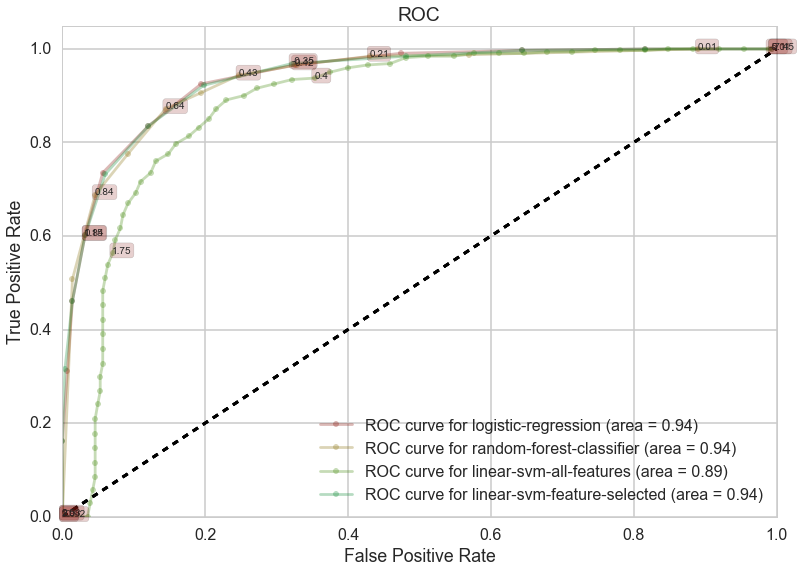

In [61]:
with sns.hls_palette(8, l=.3, s=.8):
    ax = make_roc("logistic-regression",model, ytest, Xtest, labe=200, skip=50) 
    ax = make_roc("random-forest-classifier", rfmodel, ytest, Xtest, labe=20, skip=10) 
    ax = make_roc("linear-svm-all-features", best, ytest, Xtest, labe=200, proba=False, skip=10)   
    ax = make_roc("linear-svm-feature-selected", pipeline, ytest, Xtest, labe=200, proba=False, skip=50)

## Part 3: Text Analysis

A critical part of any review are the comments. We will now proceed to analyze the comments in our q data. We will judge the predictive power of these comments, and analyze the role they play in a score's q rating.

In [14]:
import os
import math
from itertools import chain
import ast

The "unit" that we are looking at is the course-semester. In the previous notebook, for each course-semester, we had all comments, all associated Q values, and an attribute 'Positive' which is true if the average Q score for that course for that semester is greater than or equal to the average Q score across all courses for that semester. The 'Positive' attribute is false otherwise. In other words, a course-semester is defined to have an overall positive rating (Positive = True) if its Q score is above the average Q score across all courses for that semester.

We begin by loading in our complete dataframe of comments, which was stored in a csv from the last Python notebook. We will randomly subsample 10 comments per course-semester and only consider course-semesters with 10 or more comments. Our subsampled dataframe will consist of 5 columns: Course, C_Semester, Positive, C_Overall, and Sampled_Comments.

In [15]:
MIN_PER_COURSESEM_REVIEWS = 10

In [16]:
bigdf=pd.read_csv("bigdf.csv")
bigdf.reset_index(drop=True)
bigdf.head(5)

,C_Department,C_Number,Course,C_CatNum,C_ID,C_Semester,C_Year,C_Term,C_Overall,C_Workload,C_Difficulty,C_Recommendation,C_Enrollment,C_ResponseRate,I_First,I_Last,I_ID,I_Overall,I_EffectiveLectures,I_Accessible,I_GeneratesEnthusiasm,I_EncouragesParticipation,I_UsefulFeedback,I_ReturnsAssignmentsTimely,QOverall_1,QOverall_2,QOverall_3,QOverall_4,QOverall_5,QDifficulty_1,QDifficulty_2,QDifficulty_3,QDifficulty_4,QDifficulty_5,QWorkload_1,QWorkload_2,QWorkload_3,QWorkload_4,QWorkload_5,Comments,Sem_Median,Positive
0,HISTSCI,270,HISTSCI-270,58523,2697,Spring '12,2011,2,4.67,2.33,3.33,5.00,6,50.00,Rebecca,Lemov,79de794d3e2e19eb71a2033b0ec0b76d,4.67,4.33,4.00,4.33,5.00,4.50,4.00,0,0,0,1,2,0,0,2,1,0,0,2,1,0,0,[u'This course is a perfect example of what gr...,4.30,True
1,EXPOS,20.132,EXPOS-20.132,22108,1676,Fall '14,2014,1,4.10,7.10,NaN,3.50,13,76.92,Owen,Chen,1341ccb7bd27f47e68625b63b15281d1,4.50,4.60,3.70,3.90,3.90,4.10,4.60,0,1,1,4,4,0,1,2,7,3,1,3,4,1,0,"[u'The class has a fairly high work load, but ...",4.30,False
2,EXPOS,20.132,EXPOS-20.132,22108,1676,Fall '13,2013,1,3.50,2.60,3.90,3.20,13,100.00,Owen,Chen,1341ccb7bd27f47e68625b63b15281d1,3.80,4.00,2.50,3.50,4.10,4.30,4.40,0,1,1,4,4,0,1,2,7,3,1,3,4,1,0,[u'Philosophy of the State with Dr. Chen offer...,4.30,False
3,EXPOS,20.132,EXPOS-20.132,22108,1676,Fall '12,2012,1,3.73,2.47,3.67,3.47,15,100.00,Owen,Chen,1341ccb7bd27f47e68625b63b15281d1,3.87,4.33,2.64,3.93,4.18,3.64,3.82,0,1,1,4,4,0,1,2,7,3,1,3,4,1,0,[u'This was by far my favorite course. Dr. Che...,4.25,False
4,EXPOS,20.132,EXPOS-20.132,22108,1676,Fall '11,2011,1,3.85,2.00,3.54,3.62,13,100.00,Owen,Chen,1341ccb7bd27f47e68625b63b15281d1,4.08,3.75,3.31,3.92,4.46,4.23,4.08,0,1,1,4,4,0,1,2,7,3,1,3,4,1,0,"[u'Be prepared to read', u'Discussions were gr...",4.20,False


We write a helper function sample_comments that takes in a list of comments in string form and then returns one string that contains MIN_PER_COURSEM_REVIEWS randomly selected comments concatenated together.

In [17]:
def sample_comments(commentsListAsString):
    if type(commentsListAsString) != str:
        return ""
    else:
        allComments = ast.literal_eval(commentsListAsString)
        if len(allComments) >= MIN_PER_COURSESEM_REVIEWS:
            return " ".join(np.random.choice(allComments, MIN_PER_COURSESEM_REVIEWS, replace=False))
        else:
            return ""

subdf = bigdf[["Course","C_Semester","Comments","Positive","C_Overall"]].dropna()
subdf["Sampled_Comments"] = subdf.Comments.map(sample_comments)
subdf = subdf[subdf.Sampled_Comments != ""]
subdf["Course_Semester"] = subdf.Course + "-" + subdf.C_Semester
subdf = subdf[["Course","C_Semester","Course_Semester","Positive","C_Overall","Sampled_Comments"]]

Here is a look at the textual dataframe:

In [18]:
subdf.head(5)

,Course,C_Semester,Course_Semester,Positive,C_Overall,Sampled_Comments
2,EXPOS-20.132,Fall '13,EXPOS-20.132-Fall '13,False,3.50,I would inform them that this class demands ma...
3,EXPOS-20.132,Fall '12,EXPOS-20.132-Fall '12,False,3.73,This was by far my favorite course. Dr. Chen i...
13,EXPOS-20.131,Fall '14,EXPOS-20.131-Fall '14,False,3.80,"- perhaps a bit intimidating, this is an enjoy..."
14,EXPOS-20.131,Fall '13,EXPOS-20.131-Fall '13,False,3.60,Do not take this course. The readings are long...
16,EXPOS-20.131,Fall '11,EXPOS-20.131-Fall '11,True,4.50,If you are interested in political philosophy ...


Now we will convert our comments dataframe, subdf, to a spark dataframe for text analysis

In [19]:
#setup spark
import os
import findspark
import pyspark
from pyspark.sql import SQLContext

findspark.init()
print findspark.find()

conf = (pyspark.SparkConf()
        .setMaster('local')
        .setAppName('pyspark')
        .set("spark.executor.memory", "2g"))
sc = pyspark.SparkContext(conf=conf)
import sys
rdd = sc.parallelize(xrange(10), 10)
rdd.map(lambda x: sys.version).collect()
sys.version

sqlsc = SQLContext(sc)

/usr/local/opt/apache-spark/libexec


In [20]:
from pattern.en import parse
from pattern.en import pprint
from pattern.vector import stem, PORTER, LEMMA
from sklearn.feature_extraction import text
import re

punctuation = list('.,;:!?()[]{}`''\"@#$^&*+-|=~_')
stopwords = text.ENGLISH_STOP_WORDS

regex1 = re.compile(r"\.{2,}")
regex2 = re.compile(r"\-{2,}")

#Useless verbs courtesy of: http://mbweston.com/2012/11/26/writing-editing-find-and-eliminate-useless-verbs/
uselessverbs = ['be','is','are','be','was','were','been','being',
                'go','goes','went','gone','going','put','puts','putting',
                'do','does','did','done','doing',
                'come','comes','came','coming',
                'have','have','has','had','having',
                'can','could','begin','begins','began','begun','beginning',
                'seem','seems','seemed','seeming',
                'get','got','gotten','getting',
                'become','became','becoming']

We write a get parts function to parse the language in the comments. This customized get_parts function returns lists of the nouns, adjectives and verbs in the comments.

In [21]:
def get_parts(thetext):
    thetext = re.sub(regex1, ' ', thetext)
    thetext = re.sub(regex2, ' ', thetext)
    nouns = []
    descriptives = []
    verbs = []
    for i, sentence in enumerate(parse(thetext, tokenize=True, lemmata=True).split()):
        nouns.append([])
        descriptives.append([])
        verbs.append([])
        for token in sentence:
            #print token
            if len(token[4]) > 0:
                if token[1] in ['JJ', 'JJR', 'JJS']:
                    if token[4] in stopwords or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4]) == 1:
                        continue
                    descriptives[i].append(token[4])
                elif token[1] in ['NN', 'NNS']:
                    if token[4] in stopwords or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4]) == 1:
                        continue
                    nouns[i].append(token[4])
                elif token[1] in ['VB','VBP','VBZ','VBG','VBD','VBN']:
                    if token[4] in stopwords or token[4] in uselessverbs or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4]) == 1:
                        continue
                    verbs[i].append(token[4])
    out = zip(nouns, descriptives, verbs)
    nouns2 = []
    descriptives2 = []
    verbs2 = []
    for n, d, v in out:
        if len(n) != 0 and len(d) ! =0 and len(v) != 0:
            nouns2.append(n)
            descriptives2.append(d)
            verbs2.append(v)
    return nouns2, descriptives2, verbs2

In [22]:
subdf = sqlsc.createDataFrame(subdf)
subdf.show(5)

+------------+----------+--------------------+--------+---------+--------------------+
|      Course|C_Semester|     Course_Semester|Positive|C_Overall|    Sampled_Comments|
+------------+----------+--------------------+--------+---------+--------------------+
|EXPOS-20.132|  Fall '13|EXPOS-20.132-Fall...|   false|      3.5|I would inform th...|
|EXPOS-20.132|  Fall '12|EXPOS-20.132-Fall...|   false|     3.73|This was by far m...|
|EXPOS-20.131|  Fall '14|EXPOS-20.131-Fall...|   false|      3.8|- perhaps a bit i...|
|EXPOS-20.131|  Fall '13|EXPOS-20.131-Fall...|   false|      3.6|Do not take this ...|
|EXPOS-20.131|  Fall '11|EXPOS-20.131-Fall...|    true|      4.5|If you are intere...|
+------------+----------+--------------------+--------+---------+--------------------+
only showing top 5 rows



We collect the parts of speech (nouns, adjectives, and verbs) for our randomly selected comments.

In [23]:
comment_parts = subdf.rdd.map(lambda r: get_parts(r.Sampled_Comments))
comment_parts.take(1)

[([[u'philosophy',
    u'state',
    u'discussion',
    u'struggle',
    u'balance',
    u'nature',
    u'society',
    u'course'],
   [u'page',
    u'reading',
    u'day',
    u'syllabus',
    u'warning',
    u'thing',
    u'tardiness',
    u'grade'],
   [u'course'],
   [u'reading', u'understanding', u'work'],
   [u'class', u'lot'],
   [u'class', u'improvement', u'writing', u'understanding', u'writing'],
   [u'class'],
   [u'lot', u'philosophy', u'professor', u'lot'],
   [u'course', u'lot', u'reading', u'writing'],
   [u'philosophy', u'state', u'class', u'writing', u'essay', u'college'],
   [u'matter', u'society'],
   [u'page', u'entirety', u'work'],
   [u'class', u'material', u'experience'],
   [u'student', u'class', u'philosophy', u'level', u'discussion'],
   [u'class', u'philosophy', u'introduction', u'course', u'ton', u'student'],
   [u'class', u'discussion', u'class', u'lot', u'philosophy'],
   [u'state',
    u'philosophy',
    u'course',
    u'philosophy',
    u'stimulating',
  

In [24]:
parsedcomments = comment_parts.collect()

We begin our text analysis with an LDA of the nouns in the comments.

The list of lists of nouns for the first course-semester represented in parsedcomments is shown below. Each individual list of nouns represents the nouns of a sentence.

In [25]:
[e[0] for e in parsedcomments[:1]]

[[[u'philosophy',
   u'state',
   u'discussion',
   u'struggle',
   u'balance',
   u'nature',
   u'society',
   u'course'],
  [u'page',
   u'reading',
   u'day',
   u'syllabus',
   u'warning',
   u'thing',
   u'tardiness',
   u'grade'],
  [u'course'],
  [u'reading', u'understanding', u'work'],
  [u'class', u'lot'],
  [u'class', u'improvement', u'writing', u'understanding', u'writing'],
  [u'class'],
  [u'lot', u'philosophy', u'professor', u'lot'],
  [u'course', u'lot', u'reading', u'writing'],
  [u'philosophy', u'state', u'class', u'writing', u'essay', u'college'],
  [u'matter', u'society'],
  [u'page', u'entirety', u'work'],
  [u'class', u'material', u'experience'],
  [u'student', u'class', u'philosophy', u'level', u'discussion'],
  [u'class', u'philosophy', u'introduction', u'course', u'ton', u'student'],
  [u'class', u'discussion', u'class', u'lot', u'philosophy'],
  [u'state',
   u'philosophy',
   u'course',
   u'philosophy',
   u'stimulating',
   u'class',
   u'discussion',
   u'v

We flatten once so that the first five elements of ldadatardd are five sentences.

In [26]:
ldadatardd = sc.parallelize([ele[0] for ele in parsedcomments]).flatMap(lambda l: l)
ldadatardd.cache()
ldadatardd.take(5)

[[u'philosophy',
  u'state',
  u'discussion',
  u'struggle',
  u'balance',
  u'nature',
  u'society',
  u'course'],
 [u'page',
  u'reading',
  u'day',
  u'syllabus',
  u'warning',
  u'thing',
  u'tardiness',
  u'grade'],
 [u'course'],
 [u'reading', u'understanding', u'work'],
 [u'class', u'lot']]

We flatten once more so that the first five elements of ldadatardd are five words.

In [27]:
ldadatardd.flatMap(lambda word: word).take(5)

[u'philosophy', u'state', u'discussion', u'struggle', u'balance']

We compile the vocabulary of the comments with and zipWithIndex in anticipation of making the corpus vector later where it will be useful to have a place index.

In [28]:
vocabtups = (ldadatardd.flatMap(lambda word: word)
             .map(lambda word: (word, 1))
             .reduceByKey(lambda a, b: a + b)
             .map(lambda (x,y): x)
             .zipWithIndex()).cache()

We use the collectAsMap function to create vocab, a dictionary of vocabulary with words as keys and index as values.

In similar fashion, we create id2word, a dictionary with index (id) as keys and vocab as words.
The output below confirms that the relationships between id2word and vocab is correct.

In [29]:
vocab = vocabtups.collectAsMap()
id2word = vocabtups.map(lambda (x,y): (y,x)).collectAsMap()

In [30]:
id2word[0], vocab.keys()[5], vocab[vocab.keys()[5]]

(u'diaorganization', u'dynasty', 5)

We have a unique vocabulary of 4375 words.

In [31]:
len(vocab.keys())

4456

We create documents, a list of tuple lists where each tuplelist represents a sentence.

The first element of each tuple is the word id and the second element of the tuple is the number of times that the word appears in the sentence.

In [32]:
from collections import defaultdict
def get_wordID_count_tuples(wordList):
    d = defaultdict(int)
    for k in wordList:
        d[vocab[k]] += 1
    return d.items()
documents = ldadatardd.map(lambda w: get_wordID_count_tuples(w))

The below structure for documents appears to be correct.

In [33]:
documents.take(5)

[[(3552, 1),
  (2529, 1),
  (3656, 1),
  (398, 1),
  (632, 1),
  (1300, 1),
  (1358, 1),
  (1656, 1)],
 [(155, 1),
  (4228, 1),
  (3173, 1),
  (3623, 1),
  (1486, 1),
  (1717, 1),
  (3227, 1),
  (413, 1)],
 [(1358, 1)],
 [(1185, 1), (1717, 1), (1149, 1)],
 [(2055, 1), (3839, 1)]]

We store all the documents.

In [34]:
corpus = documents.collect()

We begin our unsupervised LDA topic extraction on the nouns only (instead of verbs or adjectives), since intuitively, the nouns likely reflect the main themes and topics of sentences. We will run the LDA on documents of chunk size 100 which is hopefully sufficient for the topics to converge. We set the num_topics parameter to 2 because we are looking for to separate our nouns into 2 topics.

In [117]:
import gensim
lda2 = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=2, id2word=id2word, chunksize=100, passes=10)

Above, we print the topics we find using LDA.

In [118]:
lda2.print_topics()

[u'0.163*class + 0.059*lot + 0.039*time + 0.027*student + 0.026*way + 0.021*fun + 0.020*professor + 0.019*reading + 0.018*section + 0.017*topic',
 u'0.111*course + 0.043*material + 0.038*lecture + 0.030*work + 0.027*problem + 0.018*set + 0.017*person + 0.015*language + 0.013*exam + 0.011*thing']

The first topic (let us call this Topic 0) includes the combination of words:
* class, lot, time, work, way, professor, problem, section, exam, and fun.

The second topic (let us call this Topic 1) includes the following combination of words:
* course, material, lecture, student, topic, reading, person, science, year, and lecturer.

Topic 0 seems to encompass the more interactive, qualitative, personable aspects of the course with key terms including class, professor, problem, section, and fun. Topic 1, by contrast, seems to encompass the more solitary, logistical, factual aspects of a course that a student experiences with key terms including material, lecture, student, topic, reading, year, and lecturer. One thing worth noticing is that Topic 1 includes "course" as a key term while Topic 0 includes "class". While "course" and "class" are often used interchangably in language, "class" arguably connotes a more personal, interactive experience than "course", which is more administrative and logistical and more likely to be used as an umbrella term for everything from everyday class to homework. This would support our separation of Topic 0 and 1 into more interactive/personable aspects and more logistical/solitary aspects, respectively.

In order to further evaluate our intial hypothesis that course reviews are split along two topics (interactive, qualitiative, personable aspects v. solitary, logistical aspects), we will output the words of some sentences, along with the probability of the sentence belonging to Topic 0 and Topic 1, to qualitatively check that our topics are reasonable and supported.

In [119]:
for bow in corpus[0:1200:60]:
    print bow
    print lda2.get_document_topics(bow)
    print " ".join([id2word[e[0]] for e in bow])
    print "=========================================="

[(3552, 1), (2529, 1), (3656, 1), (398, 1), (632, 1), (1300, 1), (1358, 1), (1656, 1)]
[(0, 0.50506011197258516), (1, 0.49493988802741484)]
philosophy balance society struggle nature discussion course state
[(3051, 1), (3839, 1)]
[(0, 0.50044141734017367), (1, 0.49955858265982633)]
bit class
[(923, 1), (2299, 1)]
[(0, 0.16832216747752038), (1, 0.83167783252247951)]
extension reason
[(1488, 1), (14, 1), (3839, 1)]
[(0, 0.49726283607282024), (1, 0.50273716392717982)]
person hate class
[(802, 1), (1738, 1), (1527, 1), (120, 1), (2107, 1), (3839, 1)]
[(0, 0.60640838643193884), (1, 0.3935916135680611)]
paradigm region way study intro class
[(288, 1), (3505, 1), (1954, 1), (435, 1), (3975, 1)]
[(0, 0.9130399659599534), (1, 0.086960034040046499)]
feedback process revision draft job
[(2313, 1), (2348, 1), (3727, 1)]
[(0, 0.36288478680014952), (1, 0.63711521319985054)]
family problem set
[(513, 1), (4072, 1), (1358, 1), (1076, 1), (410, 1), (2300, 1), (3839, 1)]
[(0, 0.69251284657532342), (1, 0

The "sentences" (or bag-of-words) which have a much greater probability of belonging to Topic 0 include:
* class writer load work
* class bit pass work
* class cost intervention u'very benefit reform lot issue
* class student success belief stand risk course question ability
* class kink
* way professor class discussion material
* food professor person class
* class section discussion student
* time homework week

The words in these sentences are more descriptive and relate to more creative, interactive, person-to-person aspects of a course. Specifically, "writer", "intervention", "reform", "issue", "success", "belief", "stand", "risk", "question", "kink", and "discussion" all imply rich and diverse elements of the course experience. As a Harvard student, I know that the word "section" also implies discussion and collaboration since sections for Harvard classes provide an opportunity outside of lecture to engage more closely with course material and consist of tight-knit groups.

The "sentences" which have a much greater probability of belonging to Topic 1 include:
* concept background
* reading
* thought-provoking discussion debate material staff teaching

The function below transforms X-col (which consists of word-based "sentences" (bag-of-words or "documents")) using the vectorizer which is also a parameter.
* time bit course u"must
* career course regret
* education perspective lot debate history

Words in these sentences that are not present in the previous cluster of setences and that stand out as implying more impersonal, logistical, or practical aspects of a course include "concept", "background", "reading", "material", "time", "must", "education", "history", and arguably "staff" (since "staff" is a somewhat impersonal way to refer to professors and teaching fellows). Although words like "thought-provoking", "discussion", "debate" and "teaching" do appear, it is worthwhile to note that the sentence/bag-of-words in which they appear still has a relatively high probability of belonging to Topic 0 (~35%).

The "sentences" which have more equal probabilities of belonging to Topic 0 or 1 include:
* time assignment philosophy night
* course lot
* chance education course lot style
* student reason
* way class overview study

For sentences/bag-of-words with relatively equal probabilities of belonging to Topic 0 and Topic 1, we can observe both words implying more interactive, creative aspects ("philosophy", "style", "student", "reason") and words implying more logistical aspects ("time", "assignment", "overview", "study").

From our analysis of the topic probabilities and bag-of-words above, there appears to be evidence to support our initial hypothesis that course reviews are split along two topics: Topic 0, which includes more interactive, qualitative, personable aspects of a course, and Topic 1, which includes more solitary, logistical aspects.

Let us now continue with a sentiment analysis of the adjectives in the comments using Naive Bayes. We begin by extracting the adjectives as we did before with the nouns. As before, we create adjvocabtups, a list of tuples of with adjectives and index, and we create adjvocab, a dictionary mapping adjectives to the index.

In [120]:
nbdatardd=sc.parallelize([ele[1] for ele in parsedcomments])
nbdatardd.cache()
nbdatardd.take(1)

[[[u'awesome'],
  [u'dense', u'occasional', u'terrible'],
  [u'interesting', u'intensive', u'difficult'],
  [u'interesting',
   u'mandatory',
   u'solid',
   u'important',
   u'interesting',
   u'philosophical'],
  [u'great'],
  [u'concrete', u'greater', u'effective'],
  [u'difficult', u'accurate'],
  [u'interesting', u'great'],
  [u'critical'],
  [u'difficult', u'better'],
  [u'subject', u'interesting'],
  [u'difficult', u'unnecessary'],
  [u'potential', u'interesting'],
  [u'high', u'engaging'],
  [u'fellow'],
  [u'interesting', u'willing', u'interesting'],
  [u'passionate', u'wide', u'fellow', u'similar']]]

In [121]:
adjvocabtups = (nbdatardd.flatMap(lambda l: l).flatMap(lambda word: word)
             .map(lambda word: (word, 1))
             .reduceByKey(lambda a, b: a + b)
             .map(lambda (x,y): x)
             .zipWithIndex()).cache()
adjvocab=adjvocabtups.collectAsMap()

We have 3139 unique adjectives.

In [122]:
len(adjvocab)

3202

In [123]:
import itertools
Xarraypre = nbdatardd.map(lambda l: " ".join(list(itertools.chain.from_iterable(l))))
Xarray = Xarraypre.collect()
resparray = subdf.rdd.map(lambda r: r.Positive).collect()

In [124]:
len(Xarray), len(resparray)

(1830, 1830)

All data for semester Fall '14 will be our test set and all data for all other semesters will be contained in our training data. This makes intuitive sense because we are training on "history" (earlier semesters of course data) to predict the "future (the last semester of course data). We create the mask accordingly:

In [125]:
subdf = subdf.withColumn('Train',subdf.C_Semester != "Fall '14")
mask = np.asarray(subdf.select("Train").rdd.map(lambda r: r.Train).collect());
subdf = subdf.drop('Train')

For convenience, we convert Xarray and Resparray into numpy arrays for use with sklearn.

In [126]:
X = np.array(Xarray)
y = np.array(resparray)

We then transform the adjectives into a bag of words representation and use a vectorizer to create a feature and write some support functions for Naive Bayes analysis. First, we need a helper function that that transforms X_col using vectorizer into a feature matrix with vocabulary as features.

In [127]:
def make_xy(X_col, y_col, vectorizer):
    X = vectorizer.fit_transform(X_col)
    y = y_col
    return X, y

We plan on using log-likelyhood as a scoring metric and write a support function to be able to do so.

In [128]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    negatives = y == False
    positives = ~negatives
    return prob[negatives, False].sum() + prob[positives, True].sum()

We define a function to estimate the cross-validated score (given a classifier, data, and a scoring function).

In [129]:
from sklearn.cross_validation import KFold

def cv_score(clf, x, y, score_func, nfold=5):
    result = 0
    for train, test in KFold(y.size, nfold): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf, x[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

We also define a useful function for visualizing the calibration of a probabilistic classifier (in order to recognize whether our classifier is over-confident or under-confident).

In [130]:
def calibration_plot(clf, xtest, ytest):
    prob = clf.predict_proba(xtest)[:, 1]
    outcome = ytest
    data = pd.DataFrame(dict(prob=prob, outcome=outcome))

    #group outcomes into bins of similar probability
    bins = np.linspace(0, 1, 20)
    cuts = pd.cut(prob, bins)
    binwidth = bins[1] - bins[0]
    
    #freshness ratio and number of examples in each bin
    cal = data.groupby(cuts).outcome.agg(['mean', 'count'])
    cal['pmid'] = (bins[:-1] + bins[1:]) / 2
    cal['sig'] = np.sqrt(cal.pmid * (1 - cal.pmid) / cal['count'])
        
    #the calibration plot
    ax = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    p = plt.errorbar(cal.pmid, cal['mean'], cal['sig'])
    plt.plot(cal.pmid, cal.pmid, linestyle='--', lw=1, color='k')
    plt.ylabel("Empirical P(+)")
    
    #the distribution of P(+)
    ax = plt.subplot2grid((3, 1), (2, 0), sharex=ax)
    
    plt.bar(left=cal.pmid - binwidth / 2, height=cal['count'],
            width=.95 * (bins[1] - bins[0]),
            fc=p[0].get_color())
    
    plt.xlabel("Predicted P(+)")
    plt.ylabel("Number")

In [131]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

Now we write a cross-validation loop to find the best hyper-parameters for our Naive Bayes analysis.

In [132]:
#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
maxscore=-np.inf
for alpha in alphas:
    for min_df in min_dfs:         
        vectorizer = CountVectorizer(vocabulary = adjvocab, min_df = min_df)       
        Xthis, ythis = make_xy(X, y, vectorizer)
        Xtrainthis=Xthis[mask]
        ytrainthis=ythis[mask]
        clf = MultinomialNB(alpha=alpha)
        cvscore = cv_score(clf, Xtrainthis, ytrainthis, log_likelihood)
        if cvscore > maxscore:
            maxscore = cvscore
            best_alpha, best_min_df = alpha, min_df

In [133]:
print "alpha: %f" % best_alpha
print "min_df: %f" % best_min_df

alpha: 1.000000
min_df: 0.000010


Now that we have determined the best parameters, we are ready to run the Naive Bayes classifier and create a calibration plot.

Accuracy on training data: 0.85
Accuracy on test data:     0.77


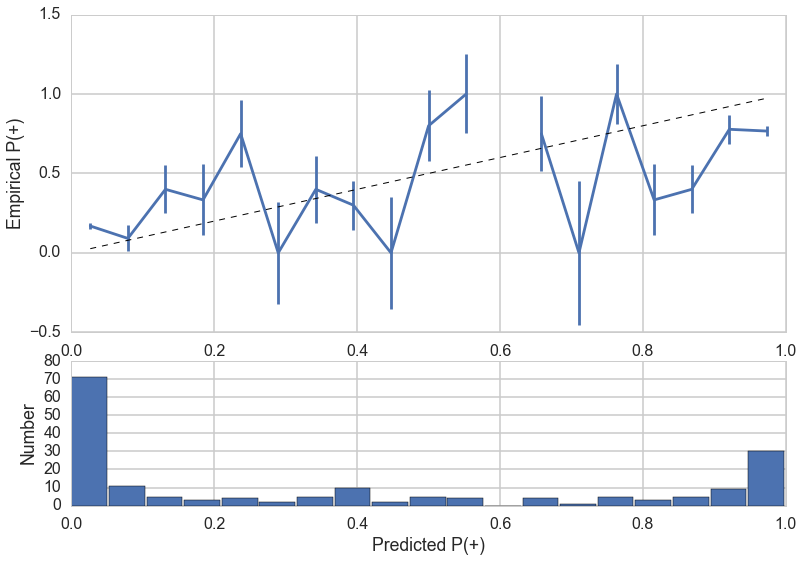

In [134]:
vectorizer = CountVectorizer(vocabulary = adjvocab, min_df=best_min_df)
X2, y2 = make_xy(X, y, vectorizer)
xtrain=X2[mask]
ytrain=y2[mask]
xtest=X2[~mask]
ytest=y2[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

# Your code here. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)
calibration_plot(clf, xtest, ytest)

Our model doesn't seem to have a problem with overfitting since the accuracy on the training set is only slightly bigger than the accuracy on the test set (0.85 vs. 0.77, respectively). Note: P(+) is the probability of positive sentiment.

The model is over-confident primarily when making predictions for predicted P(+) lower than approximately 0.2. The model is under-confident when making predictions for most P(+) values higher than 0.4. For positive sentiment predictions made with a confidence of X% where X is less than 20%, our model is correct more X% of the time. For positive sentiment predictions made with a confidence of X% where X is greater than 40, our model is correct less than X% of the time.

The calibration plot shows that the model is generally within 1 error bar of the expected performance (represented by the dotted line) for 0.4 <= P(+) <= 0.7. According to the histogram, the predictions are uniformly clustered for P(+) between 0.2 and 0.9, and have more predictions clustered at the highest and lowest P(+) values. Our model predicts, based on the adjectives, that the probability of positive sentiment is for the most part either very small (close to 0) or very large (close to 1). The clear breakup of predictions into predictions with very low P(+) and very high P(+) suggests that the adjectives in the comments have strong sentiment or that our model is very effective at extracting sentiment from adjectives. Sentiment analysis of adjectives results in either very low or very high predictions of positive sentiment probability.

The upper half of the calibration plot, however, clearly shows that we have problems with overconfidence with our predictions clustered between Predicted P(+) values of 0 and 0.2, and we have problems with underconfidence for Predicted P(+) values greater than 0.4. Therefore, although the model from verb sentiment analysis gives us strong predictions (many predictions at low predicted P(+) values and few clustered around 0.5), our predictions of low positive sentiment probability are overconfident (correct more often than expected) while our predictions of high positive sentiment probability are underconfident (correct less often than expected). In the upper half of the graph, the blue line does not align well with the dotted line, fluctuating a lot above and below.

In [135]:
nbdatardd_verbs=sc.parallelize([ele[2] for ele in parsedcomments])
nbdatardd_verbs.cache()
nbdatardd_verbs.take(1)

[[[u'say', u'enjoy'],
  [u'assign', u'offer', u'consist', u'include', u'earn'],
  [u'learn'],
  [u'assign', u'develop'],
  [u'read'],
  [u'assume', u'invest', u'earn'],
  [u'rumore'],
  [u'learn', u'expect'],
  [u'want', u'learn'],
  [u'make'],
  [u'make', u'think', u'live'],
  [u'work', u'read', u'engage'],
  [u'excite', u'think', u'make', u'disappoint'],
  [u'love'],
  [u'know', u'want', u'learn'],
  [u'read', u'frustrate'],
  [u'offer', u'cover']]]

In [136]:
verbvocabtups = (nbdatardd_verbs.flatMap(lambda l: l).flatMap(lambda word: word)
             .map(lambda word: (word, 1))
             .reduceByKey(lambda a, b: a + b)
             .map(lambda (x,y): x)
             .zipWithIndex()
).cache()
verbvocab=verbvocabtups.collectAsMap()

In [137]:
#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
maxscore=-np.inf
for alpha in alphas:
    for min_df in min_dfs:         
        vectorizer = CountVectorizer(vocabulary = verbvocab, min_df = min_df)       
        Xthis, ythis = make_xy(X, y, vectorizer)
        Xtrainthis=Xthis[mask]
        ytrainthis=ythis[mask]
        clf = MultinomialNB(alpha=alpha)
        cvscore = cv_score(clf, Xtrainthis, ytrainthis, log_likelihood)
        if cvscore > maxscore:
            maxscore = cvscore
            best_alpha, best_min_df = alpha, min_df

In [138]:
print "alpha:  %f" % best_alpha
print "min_df: %f" % best_min_df

alpha:  1.000000
min_df: 0.000010


Accuracy on training data: 0.70
Accuracy on test data:     0.63


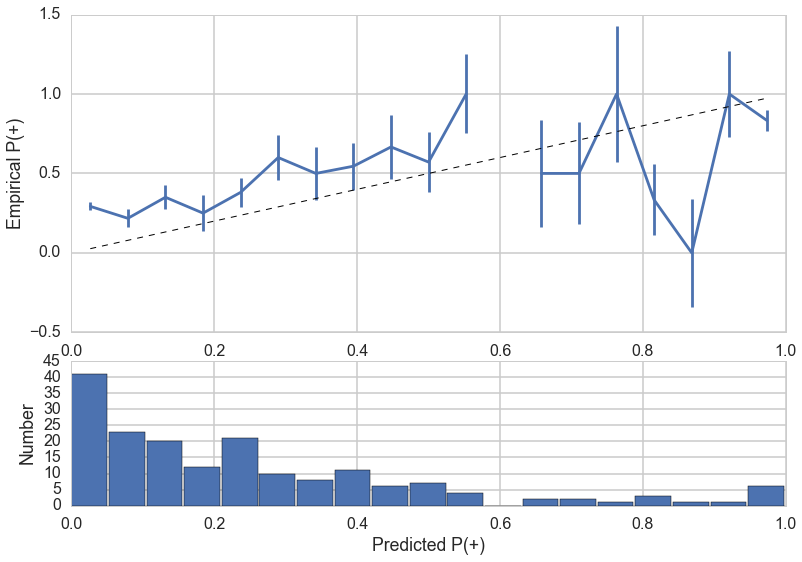

In [139]:
vectorizer = CountVectorizer(vocabulary = verbvocab, min_df=best_min_df)
X2, y2 = make_xy(X, y, vectorizer)
xtrain=X2[mask]
ytrain=y2[mask]
xtest=X2[~mask]
ytest=y2[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

# Your code here. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)
calibration_plot(clf, xtest, ytest)

Our model doesn't seem to have a problem with overfitting since the accuracy on the training set is only slightly bigger than the accuracy on the test set (0.71 vs. 0.65, respectively). Note: P(+) is the probability of positive sentiment.

The model is over-confident when making predictions for P(+) lower than approximately 0.6, and the model is under-confident when making predictions for P(+) higher than approximately 0.6. For positive sentiment predictions made with a confidence of X% where X is less than 60%, our model is correct more X% of the time. For positive sentiment predictions made with a confidence of X% where X is greater than 60, our model is correct less than X% of the time.
The calibration plot shows that the model is generally within 1 error bar of the expected performance (represented by the dotted line) for 0.3 <= P(+) <= 0.6. According to the histogram, the predictions are more heavily clustered for P(+) between 0 and 0.2 with less predictions clustered around P(+) values between 0.7 and 1.0. For P(+) vlaues between 0.3 and 0.8, however, our predictions are generally uniformly clustered. There is a trend with more predictions with lower P(+) values. Our model predicts, based on the verbs, that the probability of positive sentiment is likely between 0 and 0.2. In other words, sentiment analysis of the verbs results in low predictions of the probability of positive sentiment. The upper half of the calibration plot, however, clearly shows that we have problems with overconfidence with our predictions clustered between Predicted P(+) values of 0 and 0.2. Therefore, although the model from verb sentiment analysis gives us strong predictions (many predictions at low predicted P(+) values and few clustered around 0.5), our predictions have problems with overconfidence and underconfidence. In the upper half of the graph, the blue line does not align well with the dotted line, fluctuating a lot above and below.
Now we will proceed to combine our LDA with our Naive Bayes analysis for both adjectives and verbs and calculate to get a idea of the extent to which comments can give us idea of whether a course was rated positively or not.

As we have learned from our text analysis that adjectives provide the most useful information in distinguishing positive reviews from negative ones, let us proceed to observe what descriptives are generally found in the q comments of the best rated courses and the worst rated courses to get an idea of what words describe the best and worst courses at Harvard according to q scores. We begin by creating a subdf2, a spark data frame derived from this dataframe that we can use for this type of text analysis.

Now we will proceed to combine our LDA with our Naive Bayes analysis for both adjectives and verbs and calculate to get a idea of the extent to which comments can give us idea of whether a course was rated positively or not. Let us begin by computing the log probabilities for both the adjectives and verbs.

In [140]:
def log_probs(vocabulary):
    vectorizer2 = CountVectorizer(vocabulary = vocabulary, min_df = 0)
    X3, y3 = make_xy(X, y, vectorizer2)
    clf2 = MultinomialNB(alpha=best_alpha).fit(X3, y3)
    zeroprobs = clf2.feature_log_prob_[0]
    oneprobs = clf2.feature_log_prob_[1]
    allfeatures = vectorizer2.get_feature_names()
    logpositives = {}
    lognegatives = {}
    for i in range(0, len(zeroprobs)):
        lognegatives[allfeatures[i]] = zeroprobs[i]
    for i in range(0, len(oneprobs)):
        logpositives[allfeatures[i]] = oneprobs[i]
    return logpositives, lognegatives

In [141]:
adj_log_positives, adj_log_negatives = log_probs(adjvocab)
verb_log_positives, verb_log_negatives = log_probs(verbvocab)

Next we use Bayes theorum to compute the probability that the comments of a given q review for a semester of a course are positive

We use Bayes theorem for this (+ is the class):

$$P(+\,|\,s) = \frac{P(s\,|\,+)P(+)}{P(s\,|\,+)P(+) + P(s\,|\,-)P(-)}$$

Using the Naive Bayes assumption we find for the adjectives or verbs $\text{word}_i$:

$$P(s\,|\,+) = \prod_i P(\text{word}_i\,|\,+) \implies log(P(s\,|\,+)) = \sum_i log(P(\text{word}_i\,|\,+))$$

Use these two formulae to write a function `calc_pplus` which takes 5 arguments: a list of adjectives `adjlist` constituting a sentence, a dictionary of logpositives `lp`, a dictionary of lognegatives `ln`, the prior probability of a review being positive `pp`, and the prior probability of a review being negative `pn`; and outputs $P(+\,|\,s)$. (The prior probabilities were calculated earlier in this notebook)

In [142]:
Posdf = subdf[subdf['Positive'] == True]
PosNum = Posdf.count()
TotalNum = subdf.count()
Negdf = subdf[subdf['Positive'] == False]
NegNum = Negdf.count()
priorp = float(PosNum) / float(TotalNum)
priorn = float(NegNum) / float(TotalNum)

In [143]:
def calc_pplus(partlist, lp, ln, pp,pn):
    positiveprobs = []
    negativeprobs = []
    for part in partlist:
        positiveprobs.append(lp[part])
        negativeprobs.append(ln[part])
    possum = np.exp(sum(positiveprobs))
    negsum = np.exp(sum(negativeprobs))
    numerator = possum * pp
    denominator = (possum * pp) + (negsum * pn)
    probability = numerator / denominator 
    return probability

We write a function choose_topic which chooses which of the two LDA topics (clusters) we ought to pick for a sentence, given the bag of words for that sentence. This simply uses the higher probability cluster to make a choice. Sometimes get_document_topics only outputs one cluster if the probability is overwhelmingly high. So we need to handle this case.

In [144]:
def choose_topic(ldamodel, bow):
    tee = lda2.get_document_topics(bow)
    if len(tee)==2:
        t1,t2=tee
        if t2[1] >= t1[1]:#get higher probability topic
            topicis=t2[0]
        else:
            topicis=t1[0]
    elif len(tee)==1:#if only one was provided its very high probability. Take it
        teetuple=tee[0]
        topicis=teetuple[0]
    return topicis

We write a function get_positives_dict that combines the functions calc_pplus and choose_topic in a loop below to obtain the sentence topic and calculate the sentiment of the sentence. Note how we use the length of the noun-list for each review from parsedcomments to obtain the appropriate bag-of-words from our corpus. We store our output for each course in a dictionary with keys Course and values a list of dictionaries, one for each sentence with the topic of the sentence and the probability pplus of it "being" or predicting positive. We will run this function for both the adjectives and the verbs. The input of this function once are lognegatives and logpositive dictionaries so that we can specify whether to use the log probabilities for the adjectives or verbs and a boolean adj which will help us to specify whether to use verbs or adjectives from are parsedcomments.

In [145]:
def get_positives_dict(logpositives, lognegatives, adj = True):
    counter=0
    positivesdict={}
    Course_Semesters=subdf.map(lambda r: r.Course_Semester).collect()
    for i, course_sem in enumerate(Course_Semesters):
        course_semlist=[]
        nlist, adjlist, verblist = parsedcomments[i]
        olist = []
        if adj == True:
            olist = adjlist
        else:
            olist = verblist
        ln=len(nlist)
        localbow=corpus[counter:counter+ln]
        for bow, other, noun in zip(localbow, olist, nlist):
            doc=" ".join([id2word[e[0]] for e in bow])
            pplus=calc_pplus(other, logpositives, lognegatives, priorp, priorn)
            topicis=choose_topic(lda2, bow)
            ldict={"topic": topicis, 'pplus':pplus}
            course_semlist.append(ldict)
        positivesdict[course_sem]=course_semlist
        counter=counter+ln
    return positivesdict

In [146]:
Adj_pos_dict = get_positives_dict(adj_log_positives, adj_log_negatives,)
Verb_pos_dict = get_positives_dict(verb_log_positives, verb_log_negatives, adj = False)

We begin this process by making two dataframes, Pos_df and Neg_df, which are essentially just dataframes of the positively and negatively rated courses as defined by our criteria that positively rated courses are those that have an overall Q score higher than the average overall Q of the semester in which the rating was given and negatively rated reviews are those with an overall Q score lower than the average overall Q of the semester. Let us sample the top 10% of the positively rated courses to get an idea of the desriptives in the comments of the best q reviews and sample the bottom 10% of the negatively rated courses to get an idea of descriptives in the worst q reviews. To do so, we sort Posdf in descending order and Negdf in ascending order, and then obtain the top and bottom 10%.

We now write some Spark code to combine this dictionary with the original subdf dataframe to get a dataframe completedf which adds in the individual sentences for each review. The function extendit takes a row and from subdf and a positives_dict , gets the review_id, uses it to lookup the positives_dict above, finds the list of sentence dictionaries there, makes a copy of the dictionaries and augments them with infomation from subdf

In [147]:
def extendit(row, positives_dict):
    outlist=[]
    revs=positives_dict[row.Course_Semester]
    for r in revs:
        r2=r.copy()
        r2['Course']=row.Course
        r2['C_Semester']=row.C_Semester
        r2['Comments']=row.Sampled_Comments
        r2['Positive']=row.Positive
        r2['C_Overall']=row.C_Overall
        r2['Course_Semester'] = row.Course_Semester
        outlist.append(r2)
    return outlist

In [148]:
newdfinadj=subdf.flatMap(lambda r: extendit(r, Adj_pos_dict)).cache()
newdfinverb=subdf.flatMap(lambda r: extendit(r, Verb_pos_dict)).cache()

We use Spark flatMap to create a huge list of dictionaries, one per sentence in the review, and then combine these into a Pandas (not Spark) dataframe completedf and do so for both the Naive Bayes analysis on adjectives and verbs.

In [149]:
completedadjdf=pd.DataFrame(newdfinadj.collect())
completedadjdf.head()

,C_Overall,C_Semester,Comments,Course,Course_Semester,Positive,pplus,topic
0,3.5,Fall '13,I would inform them that this class demands ma...,EXPOS-20.132,EXPOS-20.132-Fall '13,False,0.464571,0
1,3.5,Fall '13,I would inform them that this class demands ma...,EXPOS-20.132,EXPOS-20.132-Fall '13,False,0.070638,1
2,3.5,Fall '13,I would inform them that this class demands ma...,EXPOS-20.132,EXPOS-20.132-Fall '13,False,0.393602,1
3,3.5,Fall '13,I would inform them that this class demands ma...,EXPOS-20.132,EXPOS-20.132-Fall '13,False,0.031461,1
4,3.5,Fall '13,I would inform them that this class demands ma...,EXPOS-20.132,EXPOS-20.132-Fall '13,False,0.431254,0


In [150]:
completedverbdf = pd.DataFrame(newdfinverb.collect())
completedverbdf.head()

,C_Overall,C_Semester,Comments,Course,Course_Semester,Positive,pplus,topic
0,3.5,Fall '13,I would inform them that this class demands ma...,EXPOS-20.132,EXPOS-20.132-Fall '13,False,0.428540,0
1,3.5,Fall '13,I would inform them that this class demands ma...,EXPOS-20.132,EXPOS-20.132-Fall '13,False,0.632897,1
2,3.5,Fall '13,I would inform them that this class demands ma...,EXPOS-20.132,EXPOS-20.132-Fall '13,False,0.317380,1
3,3.5,Fall '13,I would inform them that this class demands ma...,EXPOS-20.132,EXPOS-20.132-Fall '13,False,0.555524,1
4,3.5,Fall '13,I would inform them that this class demands ma...,EXPOS-20.132,EXPOS-20.132-Fall '13,False,0.418526,0


Now we group by Course_Semester and topic and get the stats for each instance of a course and topic.

In [151]:
def get_stats(group):
    statdict = {}
    statdict['Course']=[group.Course.values[0]]
    statdict['C_Semester']=[group.C_Semester.values[0]]
    statdict['Comments']=[group.Comments.values[0]]
    statdict['C_Overall']=[group.C_Overall.values[0]]
    statdict['Positive']=[group.Positive.values[0]]
    statdict['min_pplus'] = [min(group.pplus.values)]
    statdict['max_pplus'] = [max(group.pplus.values)]
    statdict['count'] = [len(group.index.values)]
    if np.isnan(np.var(group.pplus.values, ddof=1)):
        statdict['var_pplus'] = [0]
    else:
        statdict['var_pplus'] = [np.var(group.pplus.values, ddof=1)]
    statdict['mean_pplus'] = [group.pplus.mean()]
    statdataframe1 = pd.DataFrame.from_dict(statdict)
    statdataframe2 = statdataframe1.reset_index()
    return statdataframe2

In [152]:
adjdftouse=completedadjdf.groupby(['Course_Semester', 'topic']).apply(get_stats).reset_index()
adjdftouse = adjdftouse.set_index('Course_Semester')
adjdftouse.drop("level_2",axis=1,inplace=True)
adjdftouse.drop("index",axis=1,inplace=True)
adjdftouse.head()

,topic,C_Overall,C_Semester,Comments,Course,Positive,count,max_pplus,mean_pplus,min_pplus,var_pplus
Course_Semester,,,,,,,,,,,
AESTH&INTP-20-Fall '14,0,3.60,Fall '14,This is a really great class to learn about po...,AESTH&INTP-20,False,10,0.719284,0.409832,0.076903,0.030540
AESTH&INTP-20-Fall '14,1,3.60,Fall '14,This is a really great class to learn about po...,AESTH&INTP-20,False,10,0.648037,0.425638,0.114119,0.029364
AESTH&INTP-20-Spring '11,0,4.24,Spring '11,Great course to take. Just make it a point to ...,AESTH&INTP-20,False,6,0.631914,0.478280,0.375269,0.010868
AESTH&INTP-20-Spring '11,1,4.24,Spring '11,Great course to take. Just make it a point to ...,AESTH&INTP-20,False,4,0.431254,0.355846,0.264349,0.005130
AESTH&INTP-21-Fall '10,0,4.21,Fall '10,Go to lecture. Professor Thomas is the best. ...,AESTH&INTP-21,True,8,0.925193,0.463558,0.169525,0.061287


In [153]:
verbdftouse = completedverbdf.groupby(['Course_Semester', 'topic']).apply(get_stats).reset_index()
verbdftouse = verbdftouse.set_index('Course_Semester')
verbdftouse.drop("level_2",axis=1,inplace=True)
verbdftouse.drop("index",axis=1,inplace=True)
verbdftouse.head()

,topic,C_Overall,C_Semester,Comments,Course,Positive,count,max_pplus,mean_pplus,min_pplus,var_pplus
Course_Semester,,,,,,,,,,,
AESTH&INTP-20-Fall '14,0,3.60,Fall '14,This is a really great class to learn about po...,AESTH&INTP-20,False,10,0.561920,0.344675,0.202941,0.014075
AESTH&INTP-20-Fall '14,1,3.60,Fall '14,This is a really great class to learn about po...,AESTH&INTP-20,False,10,0.786677,0.480239,0.172395,0.039791
AESTH&INTP-20-Spring '11,0,4.24,Spring '11,Great course to take. Just make it a point to ...,AESTH&INTP-20,False,6,0.906296,0.610310,0.253854,0.050001
AESTH&INTP-20-Spring '11,1,4.24,Spring '11,Great course to take. Just make it a point to ...,AESTH&INTP-20,False,4,0.547304,0.384549,0.294091,0.012428
AESTH&INTP-21-Fall '10,0,4.21,Fall '10,Go to lecture. Professor Thomas is the best. ...,AESTH&INTP-21,True,8,0.561920,0.429487,0.229018,0.008924


We will proceed to do a few things with these statdfs. We will consider a classifier to be classified as positive if We will observe the true positive rate, false positive rate, false negative rate and true negative rate using the verbs Naive Bayes classifier and the Naive Bayes classifier with adjectives to determine which classifer provides more accurate predictions and whether the verbs or the adjectives of a comment give us more of an idea of whether or not the course is positively rated or negatively rated. We will also test if there is a significant correlation between the mean_pplus and the Q overall to determine if there are significant differences across comments for courses along the whole range of Q scores. We will also observe differences accross topics.
We first create separate dfs for each topic for both adjdftouse and verbdftouse. We then assume a Gaussian distribution of probability means with parameter estimates the review means and variances. Now, using the CDF of the Gaussian like we did in Homework 2, we can calculate the fraction of positive classifications for class 0 and class 1 (Use 0.5 as the threshold). First we define a function prob which takes as arguments a mean and a variance and returns the probability that a sample is positive. We will be using this function later as well. Notice we need to divide the variance by the count num in the formula below to convert from the in-sample variance to the variance of the sample mean. Put another way as compared to the paragraph above, the reason for this is that what we are interested in estimating here is not the average probability of a sentence, for say, topic 0 being positive, but rather the average probability of topic 0 in a review being positive.

In [154]:
c0dfadj=adjdftouse[adjdftouse.topic==0]
c1dfadj=adjdftouse[adjdftouse.topic==1]
c0dfverb=verbdftouse[verbdftouse.topic==0]
c1dfverb=verbdftouse[verbdftouse.topic==1]

In [155]:
from scipy.special import erf
prob= lambda mu, vari, num: .5 * (1 - erf((0.5- mu) / np.sqrt(2 * vari/float(num))))

We then define a function called get_predicteds that concatenates the classifications on to our dfs and calculates the percentage of reviews classified as positive for each topic for the adjectives and the verbs.

In [156]:
def get_predicteds(df0, df1):
    zeroprobs = []
    oneprobs = []
    zeroboolarray = []
    oneboolarray = []
    for index, row in df0.iterrows():
        probability = prob(row['mean_pplus'], row['var_pplus'], row['count'])
        if probability > 0.5:
            zeroboolarray.append(True)
            zeroprobs.append(probability)
        else:
            zeroboolarray.append(False)
    for index, row in df1.iterrows():
        probability = prob(row['mean_pplus'], row['var_pplus'], row['count'])
        if probability > 0.5:
            oneboolarray.append(True)
            oneprobs.append(probability)
        else:
             oneboolarray.append(False)
    df0['Predicted_Positive'] = zeroboolarray
    df1['Predicted_Positive'] = oneboolarray
    estimated_positive_zeroes = float(len(zeroprobs)) / float(df0.shape[0])
    estimated_positive_ones = float(len(oneprobs)) / float(df1.shape[0])
    return df0, df1, estimated_positive_zeroes, estimated_positive_ones

In [157]:
import warnings
warnings.filterwarnings('ignore')

adjdf0, adjdf1, adj_estimated_positive_zeroes, adj_estimated_positive_ones = get_predicteds(c0dfadj, c1dfadj)
verbdf0, verbdf1, verb_estimated_positive_zeroes, verb_estimated_positive_ones = get_predicteds(c0dfverb, c0dfverb)

In [158]:
adjdf0.head(5)

,topic,C_Overall,C_Semester,Comments,Course,Positive,count,max_pplus,mean_pplus,min_pplus,var_pplus,Predicted_Positive
Course_Semester,,,,,,,,,,,,
AESTH&INTP-20-Fall '14,0,3.60,Fall '14,This is a really great class to learn about po...,AESTH&INTP-20,False,10,0.719284,0.409832,0.076903,0.030540,False
AESTH&INTP-20-Spring '11,0,4.24,Spring '11,Great course to take. Just make it a point to ...,AESTH&INTP-20,False,6,0.631914,0.478280,0.375269,0.010868,False
AESTH&INTP-21-Fall '10,0,4.21,Fall '10,Go to lecture. Professor Thomas is the best. ...,AESTH&INTP-21,True,8,0.925193,0.463558,0.169525,0.061287,False
AESTH&INTP-21-Spring '12,0,3.75,Spring '12,"This class is enjoyable, especially if you lik...",AESTH&INTP-21,False,11,0.539678,0.363451,0.084393,0.022518,False
AESTH&INTP-21-Spring '13,0,4.31,Spring '13,"If you're interested in classics at all, this ...",AESTH&INTP-21,True,11,0.810953,0.442947,0.199007,0.028069,False


In [159]:
def get_rates(df):
    tpcount = 0.0
    fpcount = 0.0
    fncount = 0.0
    tncount = 0.0
    for index, row in df.iterrows():
        if row['Positive'] == row['Predicted_Positive']:
            if row['Positive'] == True:
                tpcount = tpcount + 1
            else:
                tncount = tncount + 1
        else:
            if row['Positive'] == True:
                fncount = fncount + 1
            else:
                fpcount = fpcount + 1
    zerototal = float(df.shape[0])
    tprate = tpcount / zerototal * 100
    fprate = fpcount / zerototal * 100
    fnrate = fncount / zerototal * 100
    tnrate = tncount / zerototal * 100
    ratesdict = {}
    ratesdict['tprate'] = tprate
    ratesdict['fprate'] = fprate
    ratesdict['fnrate'] = fnrate
    ratesdict['tnrate'] = tnrate
    return ratesdict

In [160]:
zeroadjrates = get_rates(adjdf0)
oneadjrates = get_rates(adjdf1)
zeroverbrates = get_rates(verbdf0)
oneverbrates = get_rates(verbdf1)

Now let us plot a bar chart of these results to get an better idea of the accuracy and implications of our verb and adjective classifiers. First we combine the dictionaries for verbs and adjectives into a single df to make plotting easier

In [161]:
def get_concat_df(dict1, dict2):
    finaldict = {}
    finaldict['True_Positive_Rate'] = [dict1['tprate'], dict2['tprate']]
    finaldict['True_Negative_Rate'] = [dict1['tnrate'], dict2['tnrate']]
    finaldict['False_Positive_Rate'] = [dict1['fprate'], dict2['fprate']]
    finaldict['False_Negative_Rate'] = [dict1['fnrate'], dict2['fnrate']]
    finaldf = pd.DataFrame.from_dict(finaldict)
    return finaldf

In [162]:
finaldfadj = get_concat_df(zeroadjrates, oneadjrates)
finaldfverbs = get_concat_df(zeroverbrates, oneverbrates)
finaldfadj.head()

,False_Negative_Rate,False_Positive_Rate,True_Negative_Rate,True_Positive_Rate
0,25.817175,1.551247,59.279778,13.351801
1,25.611111,1.833333,59.555556,13.000000


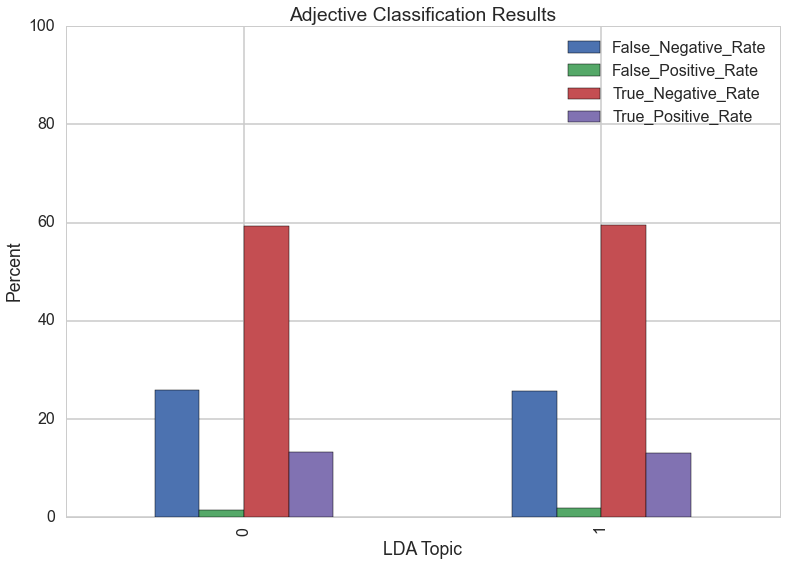

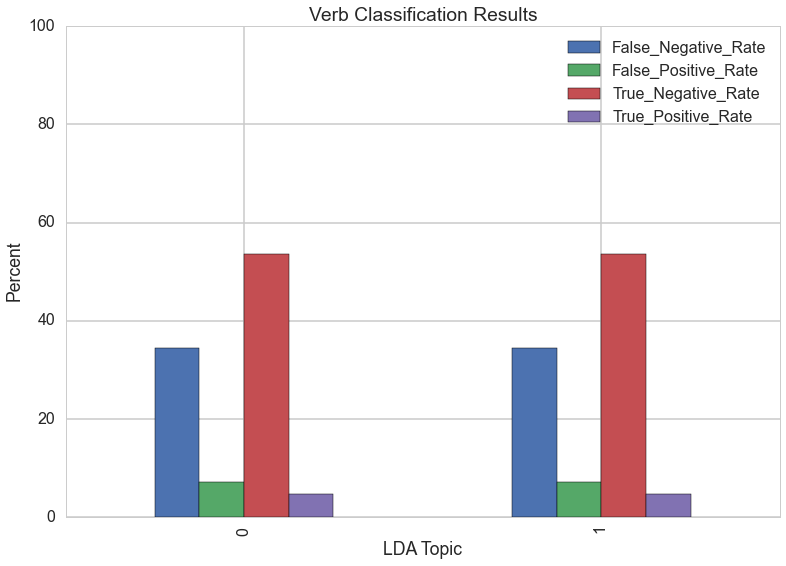

In [163]:
finaldfadj.plot(kind='bar')
plt.legend(frameon = False, loc='best')
plt.title("Adjective Classification Results")
plt.xlabel("LDA Topic")
plt.ylabel("Percent")
plt.ylim(0,100)
finaldfverbs.plot(kind ='bar')
plt.title("Verb Classification Results")
plt.xlabel("LDA Topic")
plt.ylabel("Percent")
plt.legend(frameon = False, loc='best')
plt.ylim(0,100);

ADJECTIVES:

Our results using adjectives from both topics have very high true negative rates and very low (almost 0) false positive rates, which suggests that our model is extremely successful at predicting/recognizing negative sentiment from analysis of adjectives. Our true positive and false negative rates are approximately equivalent using adjectives sentiment analysis, which suggests that our model is not very effective (has approximately 50% accuracy) at estimating positive sentiment using adjectives.

VERBS:

The verbs from both topics have very high true negative rate, relatively high false negative rates, and relatively lower false positive and true positive rates. The true positive rate is lowest of all rates for verbs of both topics. The true negative and false positive rates refer to comments that are actually negative while the true positive and false negative rates refer to comments that are actually positive. The high true negative and false positive rates mean that a majority of verbs have negative sentiment, which is in agreement with our calibration plots above which indicated a clustering of predictions near low (close to 0) P(+) values. The true negative rate (red bar) is significantly higher than our false positive rate (blue bar) which indicates that our model is effective at recognizing negative sentiment. Ideally, the blue bar should be as close to 0 as possible (no false positives), but the significant discrepancy between the true negative and false positives rates indicate that our model is effective to a degree at predicting sentiment using verb sentiment analysis. Our model is less effective at predicting positive sentiment using verbs as we can see that the false negative rate is greater than the true positive rate.

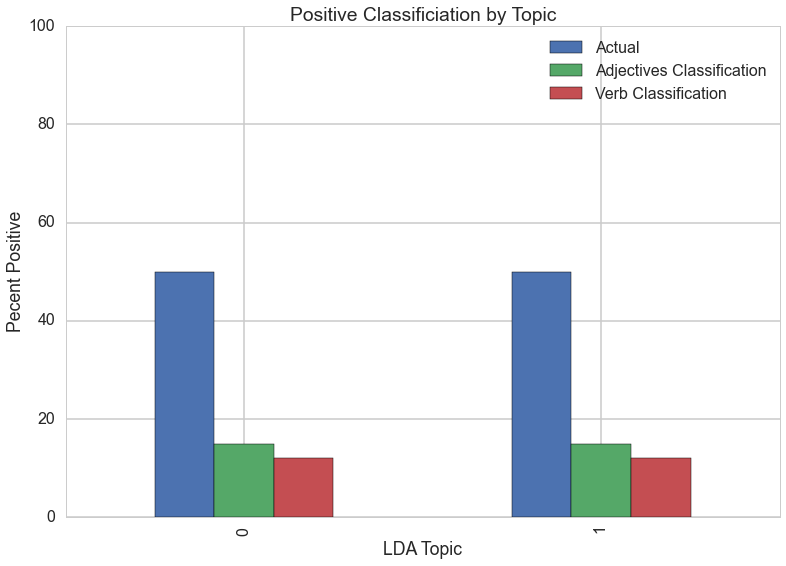

In [164]:
positivesdictfinal = {}
positivesdictfinal['Adjectives Classification'] = [adj_estimated_positive_zeroes * 100, adj_estimated_positive_ones * 100]
positivesdictfinal['Verb Classification'] = [verb_estimated_positive_zeroes  * 100, verb_estimated_positive_ones * 100]
positivesdictfinal['Actual'] = [50, 50]
positivesdf = pd.DataFrame.from_dict(positivesdictfinal)
positivesdf.plot(kind='bar')
plt.legend(frameon = False, loc='best')
plt.title("Positive Classificiation by Topic")
plt.xlabel("LDA Topic")
plt.ylabel("Pecent Positive")
plt.ylim(0,100);

As we have learned from our text analysis that adjectives provide the most useful information in distinguishing positive reviews from negative ones, let us proceed to observe what descriptives are generally found in the q comments of the best rated courses and the worst rated courses to get an idea of what words describe the best and worst courses at Harvard according to q scores. We begin by creating a subdf2, a spark data frame derived from this dataframe that we can use for this type of text analysis.
We begin this process by making two dataframes, Pos_df and Neg_df, which are essentially just dataframes of the positively and negatively rated courses as defined by our criteria that positively rated courses are those that have an overall Q score higher than the average overall Q of the semester in which the rating was given and negatively rated reviews are those with an overall Q score lower than the average overall Q of the semester. Let us sample the top 10% of the positively rated courses to get an idea of the desriptives in the comments of the best q reviews and sample the bottom 10% of the negatively rated courses to get an idea of descriptives in the worst q reviews. To do so, we sort Posdf in descending order and Negdf in ascending order, and then obtain the top and bottom 10%.

In [165]:
Posdf = subdf[subdf['Positive'] == True]
PosNum = Posdf.count()
Top10 = int(0.1 * PosNum)
Posdf = Posdf.rdd.sortBy(lambda x: x.C_Overall, ascending = False)
Posdf = sqlsc.createDataFrame(Posdf.take(Top10))
Negdf = subdf[subdf['Positive'] == False]
NegNum = Negdf.count()
Bottom10 = int(0.1 * NegNum)
Negdf = Negdf.rdd.sortBy(lambda x: x.C_Overall)
Negdf = sqlsc.createDataFrame(Negdf.take(Bottom10))

Now we extract the adjectives in the positive and negative reviews.

In [166]:
Positive_comment_parts = Posdf.rdd.map(lambda r: get_parts(r.Sampled_Comments)).collect()
Negative_comment_parts = Negdf.rdd.map(lambda r: get_parts(r.Sampled_Comments)).collect()

Let us take a look at the sample of the adjectives in the negatively rated courses and positively rated courses.

`get_top` is a helper function that takes in the part of speech (N, A, V), `Negative_comment_parts`, `Positive_comment_parts`, number of word to show, and other specifications to create a Wordle Visualization of the specified number of top positive and top negative words.

In [167]:
from pytagcloud import create_tag_image, make_tags
from pytagcloud.lang.counter import get_tag_counts
from IPython.display import Image

def get_top(part_of_speech,neg_comment_parts,pos_comment_parts, num_words_to_show, maxsize=120,negImgSize = (1200,1000),posImgSize=(1200,1000),background=(0, 0, 0, 0)):
    if part_of_speech == 'N' or part_of_speech == 0 :
        i = 0
    elif part_of_speech == 'A' or part_of_speech == 1:
        i = 1
    elif part_of_speech == 'V' or part_of_speech == 2:
        i = 2
    else:
        i = -1
    negativerdd = sc.parallelize([ele[i] for ele in neg_comment_parts])
    positiverdd = sc.parallelize([ele[i] for ele in pos_comment_parts])

    top_neg = (negativerdd.flatMap(lambda l: l).flatMap(lambda word: word)
               .map(lambda w: (w, 1))
               .reduceByKey(lambda x, y: x + y)
               .collect())
    sorted_neg = sorted(top_neg, key=lambda tup: tup[1], reverse=True)
    
    top_pos = (positiverdd.flatMap(lambda l: l).flatMap(lambda word: word)
               .map(lambda w: (w, 1))
               .reduceByKey(lambda x, y: x + y)
               .collect())
    sorted_pos = sorted(top_pos, key=lambda tup: tup[1], reverse=True)

    neg_tags = make_tags(sorted_neg[:num_words_to_show], maxsize=maxsize)
    create_tag_image(neg_tags, 'Top_20_Negative_%s.png'%part_of_speech, size=negImgSize, fontname='Lobster',background=(0, 0, 0, 0))
    pos_tags = make_tags(sorted_pos[:num_words_to_show], maxsize=maxsize)
    create_tag_image(pos_tags, 'Top_20_Positive_%s.png'%part_of_speech, size=posImgSize, fontname='Lobster',background=(0, 0, 0, 0))
    return negativerdd, sorted_neg, neg_tags, positiverdd, sorted_pos, 

ImportError: No module named pygame

Let us now retrieve the top 20 descriptives for the negatively rated and positively rated reviews using some flattening and a spark word count algorithm. We can also create wordle visualizations to help us better observe the distinctions between the descriptives of positively and negatively rated words.

In [ ]:
get_top('N',Negative_comment_parts,Positive_comment_parts, num_words_to_show=40, maxsize=120,negImgSize = (1200,1000),posImgSize=(1200,1000));
get_top('A',Negative_comment_parts,Positive_comment_parts, num_words_to_show=40, maxsize=120,negImgSize = (1400,1000),posImgSize=(1200,1000));
get_top('V',Negative_comment_parts,Positive_comment_parts, num_words_to_show=40, maxsize=120,negImgSize = (1200,1000),posImgSize=(1200,1000));

In [ ]:
from IPython.display import Image
Image(filename='Top_20_Positive_N.png')

In [ ]:
Image(filename='Top_20_Negative_N.png')

In [ ]:
Image(filename='Top_20_Positive_A.png')

In [ ]:
Image(filename='Top_20_Negative_A.png')

In [ ]:
Image(filename='Top_20_Positive_V.png')

In [ ]:
Image(filename='Top_20_Negative_V.png')

## References

http://www.fas.harvard.edu/~evals/  
http://www.clipartpanda.com/categories/cool-question-marks